In [1]:
# librearies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Cargar el archivo CSV
file_path = "C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/data/bd-test.csv"
data = pd.read_csv(
    file_path,
    sep=";",
    parse_dates=['fecha'],
    date_format='%Y-%m'
)

In [3]:
# Mostrar los primeros registros
data.head()

,id_sku,AAAA,MM,fecha,Cantidad
0,SKU_1,2021,7,2021-07-01,7745
1,SKU_1,2021,8,2021-08-01,8897
2,SKU_1,2021,9,2021-09-01,8040
3,SKU_1,2021,10,2021-10-01,10870
4,SKU_1,2021,11,2021-11-01,10691


In [4]:
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id_sku    1656 non-null   object        
 1   AAAA      1656 non-null   int64         
 2   MM        1656 non-null   int64         
 3   fecha     1656 non-null   datetime64[ns]
 4   Cantidad  1656 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 64.8+ KB


In [5]:
# descripción de los datos
data.describe()

,AAAA,MM,fecha,Cantidad
count,1656.000000,1656.000000,1656,1656.000000
mean,2022.500000,6.500000,2022-12-16 02:40:00,3734.913043
min,2021.000000,1.000000,2021-07-01 00:00:00,1.000000
25%,2022.000000,3.750000,2022-03-24 06:00:00,1143.250000
50%,2022.500000,6.500000,2022-12-16 12:00:00,2066.500000
75%,2023.000000,9.250000,2023-09-08 12:00:00,3886.250000
max,2024.000000,12.000000,2024-06-01 00:00:00,48990.000000
std,0.957716,3.453095,NaN,5209.772144


In [6]:
# Comprobar valores nulos
data.isnull().sum()

id_sku      0
AAAA        0
MM          0
fecha       0
Cantidad    0
dtype: int64

In [7]:
# Visualización de las series por SKU
unique_skus = data['id_sku'].unique()
print(f"\nNúmero de SKUs únicos: {len(unique_skus)}")
print(f"SKUs únicos: {unique_skus}")


Número de SKUs únicos: 46
SKUs únicos: ['SKU_1' 'SKU_10' 'SKU_13' 'SKU_14' 'SKU_15' 'SKU_16' 'SKU_17' 'SKU_18'
 'SKU_19' 'SKU_2' 'SKU_20' 'SKU_22' 'SKU_25' 'SKU_26' 'SKU_27' 'SKU_28'
 'SKU_29' 'SKU_30' 'SKU_31' 'SKU_32' 'SKU_33' 'SKU_34' 'SKU_35' 'SKU_36'
 'SKU_37' 'SKU_38' 'SKU_39' 'SKU_4' 'SKU_45' 'SKU_46' 'SKU_47' 'SKU_48'
 'SKU_49' 'SKU_5' 'SKU_50' 'SKU_51' 'SKU_52' 'SKU_53' 'SKU_6' 'SKU_63'
 'SKU_64' 'SKU_65' 'SKU_66' 'SKU_7' 'SKU_8' 'SKU_9']


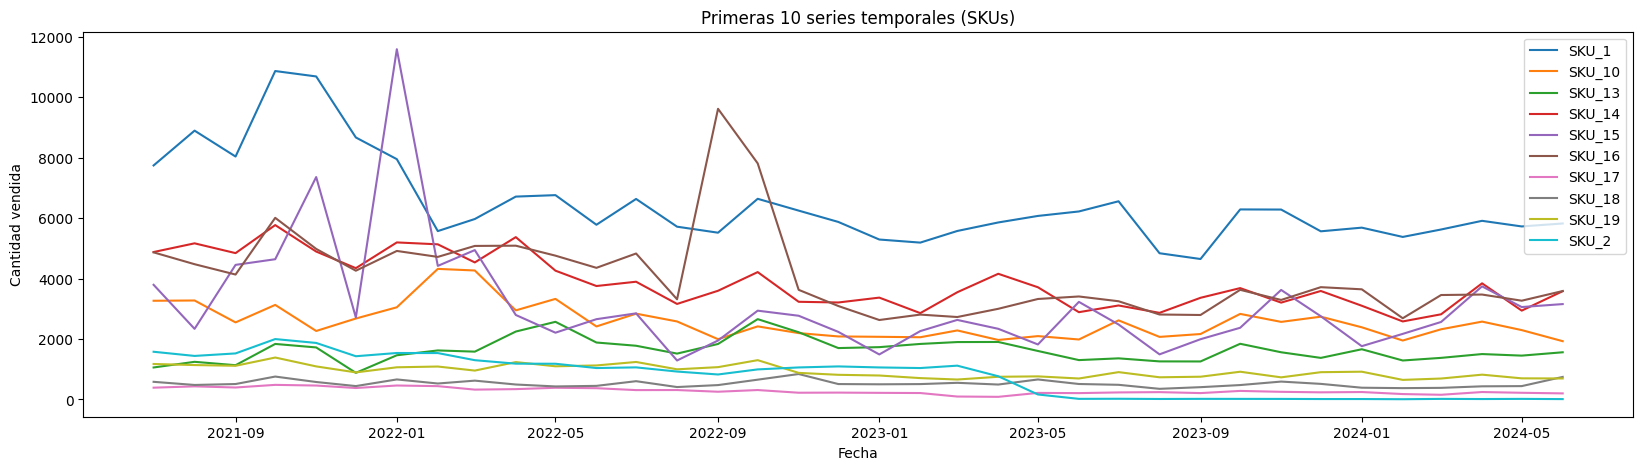

In [8]:
# Visualización de las primeras 5 series temporales
plt.figure(figsize=(20, 5))
for sku in unique_skus[:10]:
    sku_data = data[data['id_sku'] == sku]
    plt.plot(sku_data['fecha'], sku_data['Cantidad'], label=sku)

plt.title('Primeras 10 series temporales (SKUs)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.legend()
plt.show()

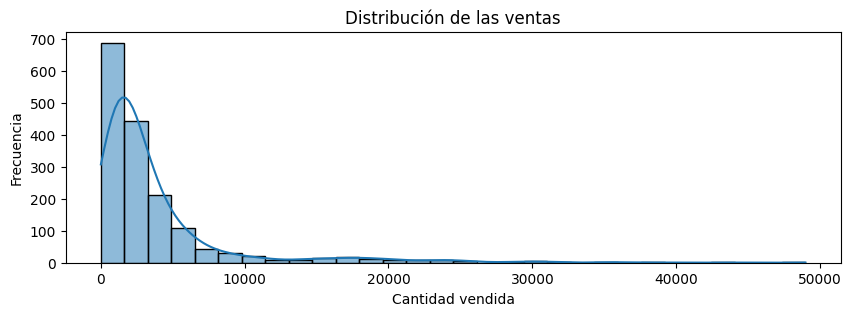

In [9]:
# Distribución de ventas
plt.figure(figsize=(10, 3))
sns.histplot(data['Cantidad'], bins=30, kde=True)
plt.title('Distribución de las ventas')
plt.xlabel('Cantidad vendida')
plt.ylabel('Frecuencia')
plt.show()

### Outliers

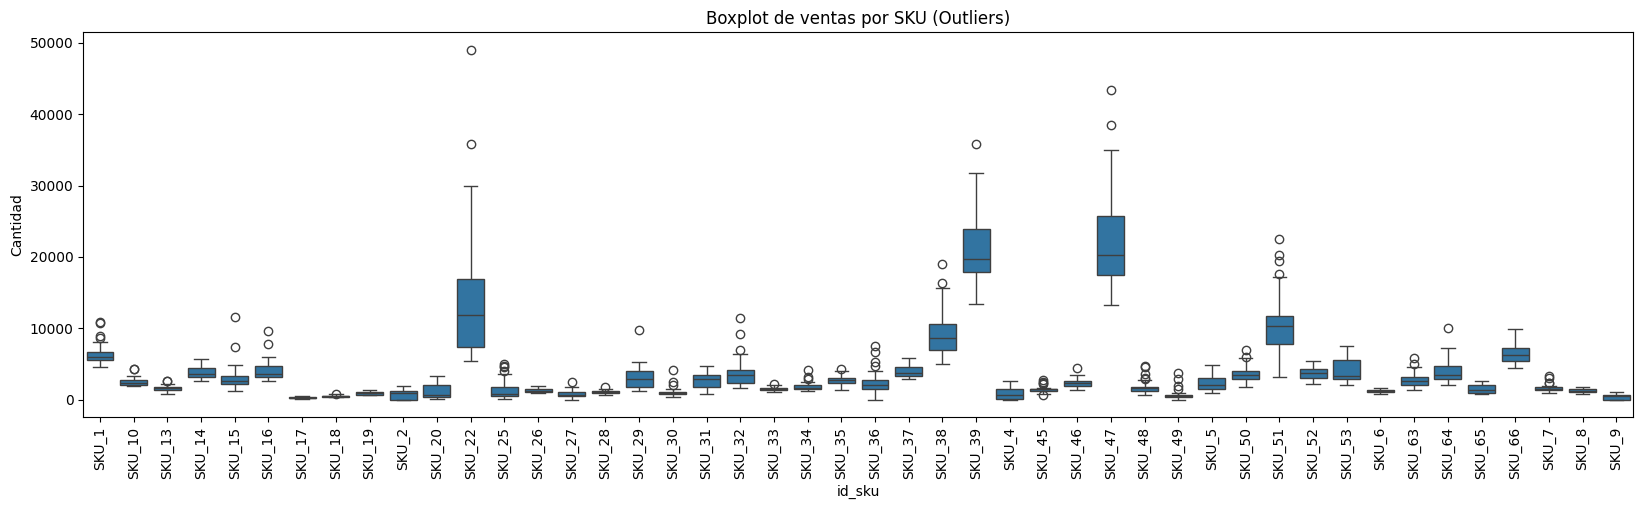

In [10]:
# Outliers por SKU
plt.figure(figsize=(20, 5))
sns.boxplot(data=data, x='id_sku', y='Cantidad')
plt.title('Boxplot de ventas por SKU (Outliers)')
plt.xticks(rotation=90)
plt.show()

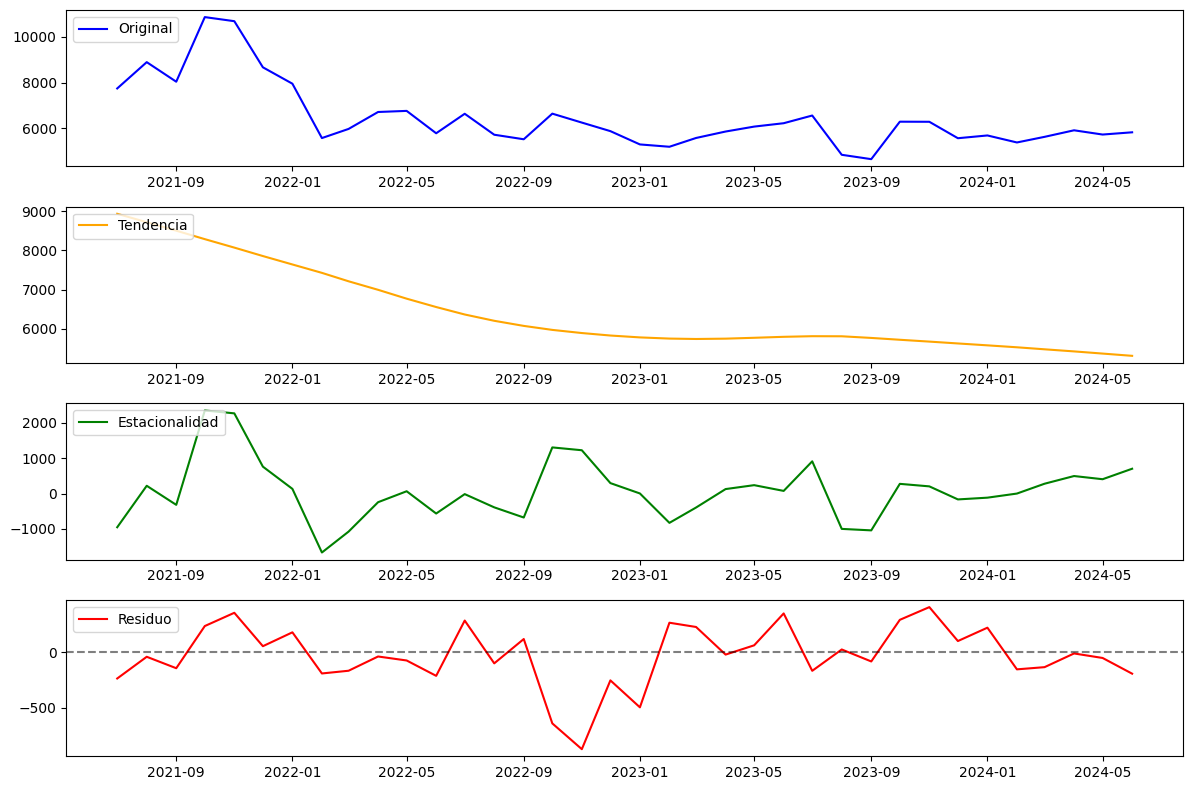

Outliers encontrados: 1
fecha
2022-11-01   -869.896395
Name: resid, dtype: float64


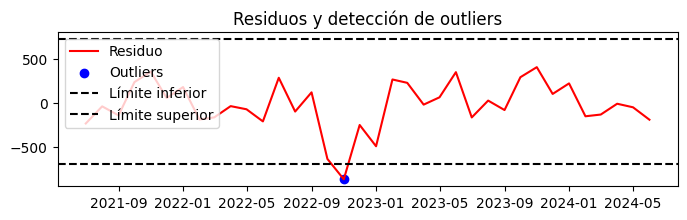

In [11]:
# identificar los outliers

# Seleccionar una serie SKU para análisis inicial
sku = 'SKU_1'
serie_sku = data[data['id_sku'] == sku].set_index('fecha')['Cantidad']

# Descomposición STL
stl = STL(serie_sku, seasonal=13)  # 13 para series mensuales (ajustar según periodicidad)
result = stl.fit()

# Extraer componentes
tendencia = result.trend
estacionalidad = result.seasonal
residuo = result.resid

# Graficar descomposición
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(serie_sku, label="Original", color='blue')
plt.legend(loc="upper left")
plt.subplot(4, 1, 2)
plt.plot(tendencia, label="Tendencia", color='orange')
plt.legend(loc="upper left")
plt.subplot(4, 1, 3)
plt.plot(estacionalidad, label="Estacionalidad", color='green')
plt.legend(loc="upper left")
plt.subplot(4, 1, 4)
plt.plot(residuo, label="Residuo", color='red')
plt.axhline(0, linestyle='--', color='black', alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Detección de outliers en residuos
# Usamos IQR (Rango Intercuartílico)
Q1 = residuo.quantile(0.25)
Q3 = residuo.quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

outliers = residuo[(residuo < outlier_threshold_low) | (residuo > outlier_threshold_high)]

# Mostrar resultados
print(f"Outliers encontrados: {len(outliers)}")
print(outliers)

# Graficar residuos y outliers
plt.figure(figsize=(8, 2))
plt.plot(residuo, label="Residuo", color='red')
plt.scatter(outliers.index, outliers, color='blue', label="Outliers")
plt.axhline(outlier_threshold_low, color='black', linestyle='--', label="Límite inferior")
plt.axhline(outlier_threshold_high, color='black', linestyle='--', label="Límite superior")
plt.legend(loc="upper left")
plt.title("Residuos y detección de outliers")
plt.show()

In [12]:
outliers_summary = []

# Procesar cada SKU
for sku in data['id_sku'].unique():
    serie_sku = data[data['id_sku'] == sku].set_index('fecha')['Cantidad']
    
    # Descomposición STL
    stl = STL(serie_sku, seasonal=13)
    result = stl.fit()
    residuo = result.resid
    
    # Detección de outliers
    Q1 = residuo.quantile(0.25)
    Q3 = residuo.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold_low = Q1 - 1.5 * IQR
    outlier_threshold_high = Q3 + 1.5 * IQR
    outliers = residuo[(residuo < outlier_threshold_low) | (residuo > outlier_threshold_high)]
    
    # Guardar resultados
    for date, value in outliers.items():
        outliers_summary.append({'sku': sku, 'fecha': date, 'residuo': value})

# Convertir a DataFrame
outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df)

        sku      fecha      residuo
0     SKU_1 2022-11-01  -869.896395
1    SKU_10 2023-02-01  -356.679787
2    SKU_10 2023-03-01  -305.937240
3    SKU_15 2022-01-01  1239.330999
4    SKU_15 2022-11-01  -998.898425
..      ...        ...          ...
103  SKU_66 2023-06-01 -1127.947250
104  SKU_66 2024-03-01  -897.831753
105   SKU_7 2022-12-01  -460.032083
106   SKU_7 2023-06-01   362.810617
107   SKU_8 2022-11-01   214.207714

[108 rows x 3 columns]


In [13]:
# Guardar resultados detección de outliers
outliers_df.to_csv("C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/data/outliers_detectados.csv", index=False)

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data_for_analysis(df):
    """
    Prepara los datos para el análisis convirtiendo el DataFrame a formato adecuado
    
    Args:
        df: DataFrame con columnas [id_sku, AAAAMM, fecha, Cantidad]
    
    Returns:
        DataFrame pivoteado con fechas como índice y SKUs como columnas
    """
    # Asegurarse que la fecha está en formato datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Convertir Cantidad a numérico
    df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce')
    
    # Pivotar el DataFrame
    df_pivot = df.pivot(index='fecha', columns='id_sku', values='Cantidad')
    
    # Ordenar por fecha
    df_pivot = df_pivot.sort_index()
    
    return df_pivot

def detect_outliers_combined(series, period=12):
    """
    Detecta outliers usando tanto STL como Z-score modificado
    
    Args:
        series: Serie temporal de ventas
        period: Período de estacionalidad (12 para datos mensuales)
    
    Returns:
        DataFrame con los componentes y outliers detectados
    """
    # Verificar que la serie tiene suficientes datos
    if len(series) < 2 * period:
        raise ValueError(f"La serie necesita al menos {2 * period} observaciones para el análisis STL")
    
    # Verificar que no hay valores nulos
    if series.isnull().any():
        series = series.interpolate(method='linear')
    
    # 1. Descomposición STL
    decomposition = seasonal_decompose(series, period=period)
    
    # Obtener componentes
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # 2. Detectar outliers en residuos usando Z-score modificado
    median_residual = np.nanmedian(residual)
    mad_residual = stats.median_abs_deviation(residual, nan_policy='omit')
    
    # Evitar división por cero
    if mad_residual == 0:
        modified_zscore = np.zeros_like(residual)
    else:
        modified_zscore = 0.6745 * (residual - median_residual) / mad_residual
    
    # 3. Crear máscara de outliers
    outliers_mask = np.abs(modified_zscore) > 3
    
    # 4. Crear DataFrame con resultados
    results = pd.DataFrame({
        'original': series,
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual,
        'modified_zscore': modified_zscore,
        'is_outlier': outliers_mask
    })
    
    return results

def plot_outlier_analysis(analysis_results, sku_name):
    """
    Visualiza los resultados del análisis de outliers
    
    Args:
        analysis_results: DataFrame con los resultados del análisis
        sku_name: Nombre del SKU para el título
    """
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(f'Análisis de Outliers - {sku_name}', fontsize=16)
    
    # Serie original con outliers marcados
    axes[0].plot(analysis_results.index, analysis_results['original'], label='Original')
    outliers = analysis_results[analysis_results['is_outlier']]['original']
    if not outliers.empty:
        axes[0].scatter(outliers.index, outliers, color='red', label='Outliers')
        # Agregar etiquetas con valores para los outliers
        for idx, value in outliers.items():
            axes[0].annotate(f'{value:.0f}', 
                           (idx, value), 
                           xytext=(5, 5), 
                           textcoords='offset points')
    axes[0].set_title(f'Serie Original con Outliers (Total: {len(outliers)})')
    axes[0].legend()
    
    # Componentes STL
    axes[1].plot(analysis_results.index, analysis_results['trend'], label='Tendencia')
    axes[1].plot(analysis_results.index, analysis_results['seasonal'], label='Estacionalidad')
    axes[1].set_title('Componentes STL')
    axes[1].legend()
    
    # Residuos
    axes[2].plot(analysis_results.index, analysis_results['residual'], label='Residuos')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_title('Residuos')
    
    # Z-scores modificados
    axes[3].plot(analysis_results.index, analysis_results['modified_zscore'], label='Z-score Modificado')
    axes[3].axhline(y=3, color='r', linestyle='--', label='Umbral Superior')
    axes[3].axhline(y=-3, color='r', linestyle='--', label='Umbral Inferior')
    axes[3].set_title('Z-scores Modificados')
    axes[3].legend()
    
    plt.tight_layout()
    return fig

def analyze_sales_outliers(df_original, period=12):
    """
    Analiza y trata outliers en datos de ventas, mostrando solo series con outliers
    
    Args:
        df_original: DataFrame con columnas [id_sku, AAAAMM, fecha, Cantidad]
        period: Período de estacionalidad
    
    Returns:
        dict con resultados por SKU
    """
    # Preparar datos
    df = prepare_data_for_analysis(df_original)
    results = {}
    skus_con_outliers = []
    
    for sku in df.columns:
        series = df[sku].copy()
        
        try:
            # Detectar outliers
            analysis = detect_outliers_combined(series, period=period)
            
            # Verificar si hay outliers
            if analysis['is_outlier'].any():
                skus_con_outliers.append(sku)
                
                # Tratar outliers
                treated_series = series.copy()
                mask = analysis['is_outlier']
                expected_values = analysis['trend'] + analysis['seasonal']
                treated_series[mask] = expected_values[mask]
                
                # Guardar resultados
                results[sku] = {
                    'original': series,
                    'treated': treated_series,
                    'analysis': analysis,
                    'num_outliers': mask.sum()
                }
                
                # Visualizar resultados
                plot_outlier_analysis(analysis, sku)
                plt.show()
            
        except Exception as e:
            print(f"Error al procesar {sku}: {str(e)}")
            continue
    
    print(f"\nSe encontraron outliers en {len(skus_con_outliers)} de {len(df.columns)} SKUs")
    if skus_con_outliers:
        print("\nSKUs con outliers:")
        for sku in skus_con_outliers:
            print(f"- {sku}: {results[sku]['num_outliers']} outliers")
    
    return results

def generate_outlier_report(results):
    """
    Genera un reporte detallado de los cambios realizados
    
    Args:
        results: Diccionario con resultados del análisis
    
    Returns:
        DataFrame con resumen de cambios
    """
    report_data = []
    
    for sku, data in results.items():
        analysis = data['analysis']
        outliers = analysis[analysis['is_outlier']]
        
        if not outliers.empty:
            for idx in outliers.index:
                report_data.append({
                    'SKU': sku,
                    'Fecha': idx,
                    'Valor_Original': outliers.loc[idx, 'original'],
                    'Valor_Ajustado': data['treated'][idx],
                    'Diferencia': outliers.loc[idx, 'original'] - data['treated'][idx],
                    'Diferencia_%': ((outliers.loc[idx, 'original'] - data['treated'][idx]) / data['treated'][idx] * 100),
                    'Z_score': outliers.loc[idx, 'modified_zscore']
                })
    
    df_report = pd.DataFrame(report_data)
    if not df_report.empty:
        df_report = df_report.sort_values(['SKU', 'Fecha'])
        df_report['Diferencia_%'] = df_report['Diferencia_%'].round(2)
    
    return df_report

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2161.92534722 1960.17534722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


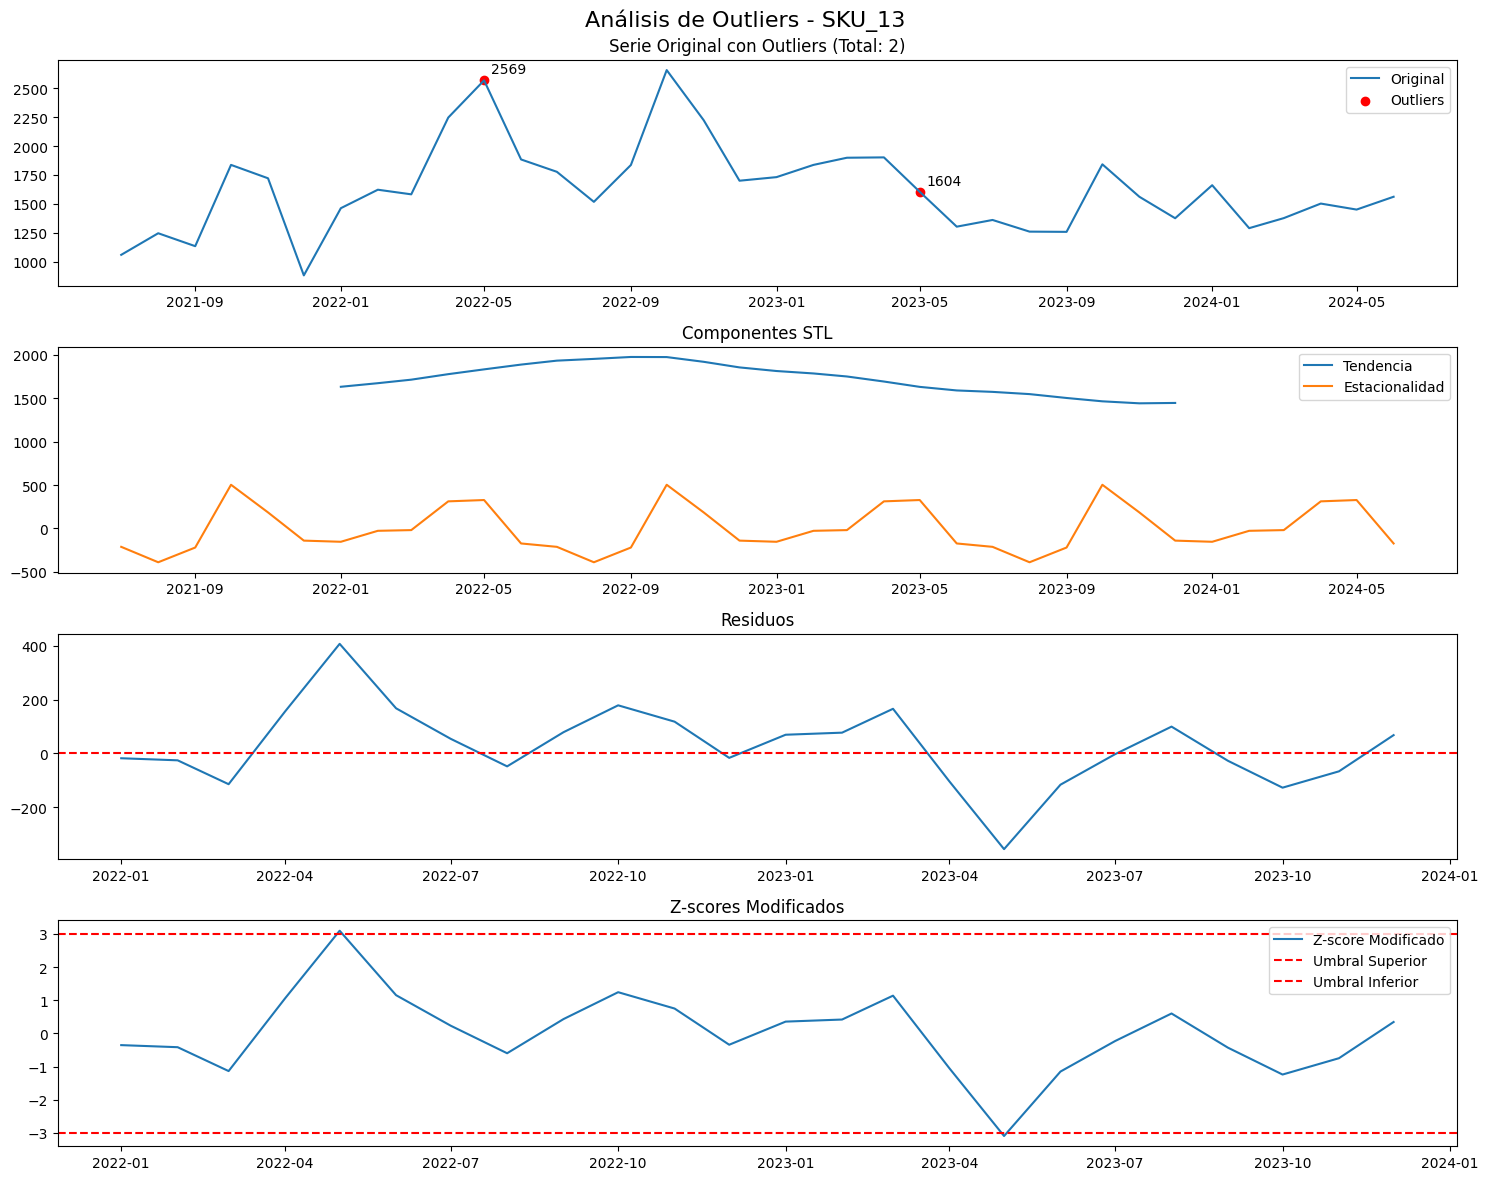

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7491.47743056 5339.43576389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


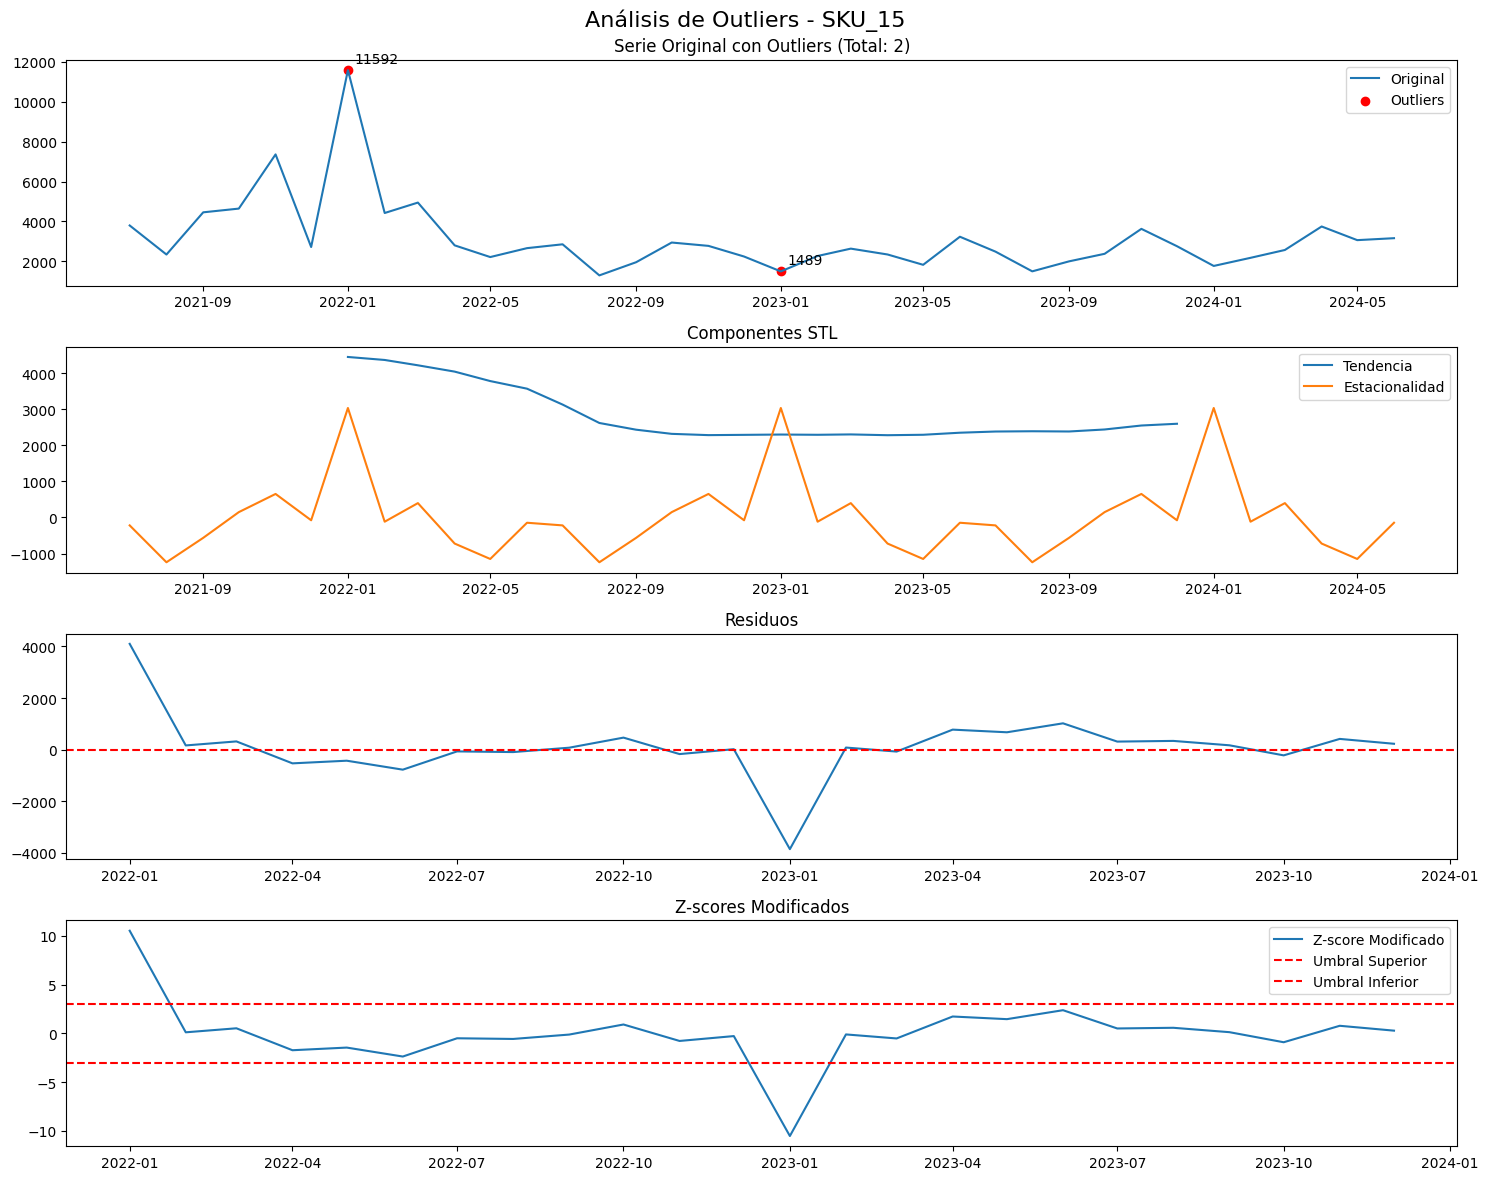

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6913.92881944 5481.05381944]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


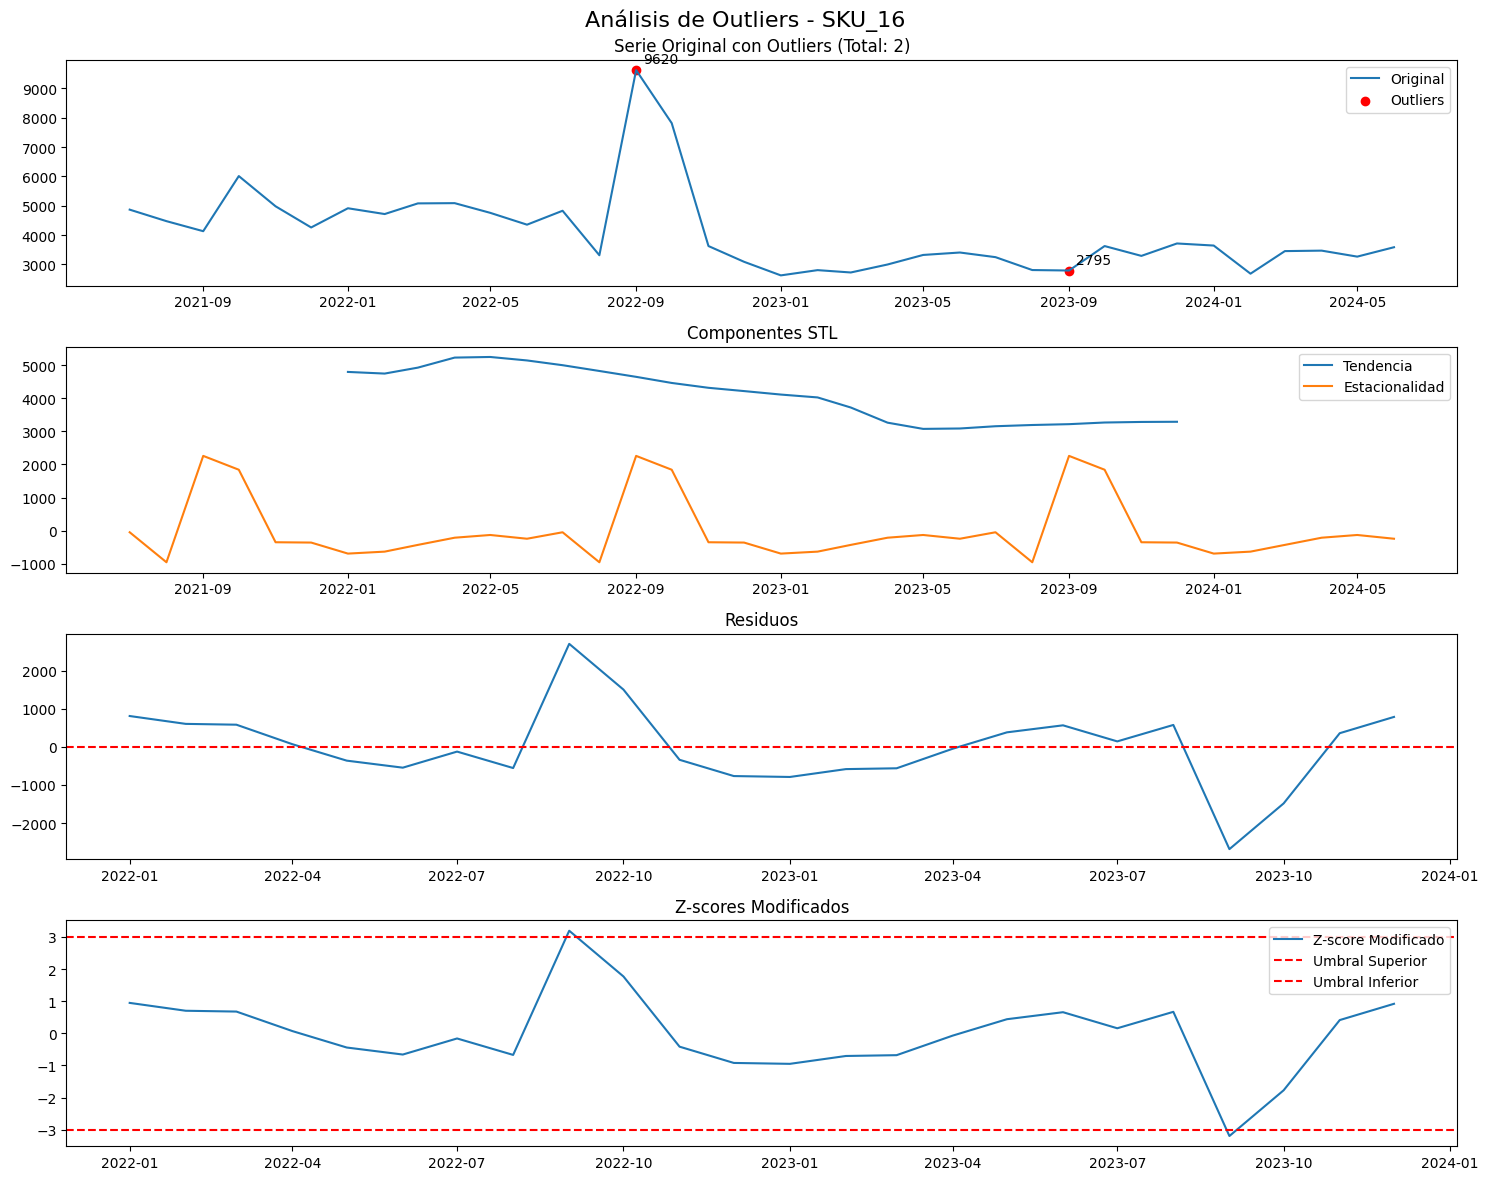

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7267.74305556 7198.90972222]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


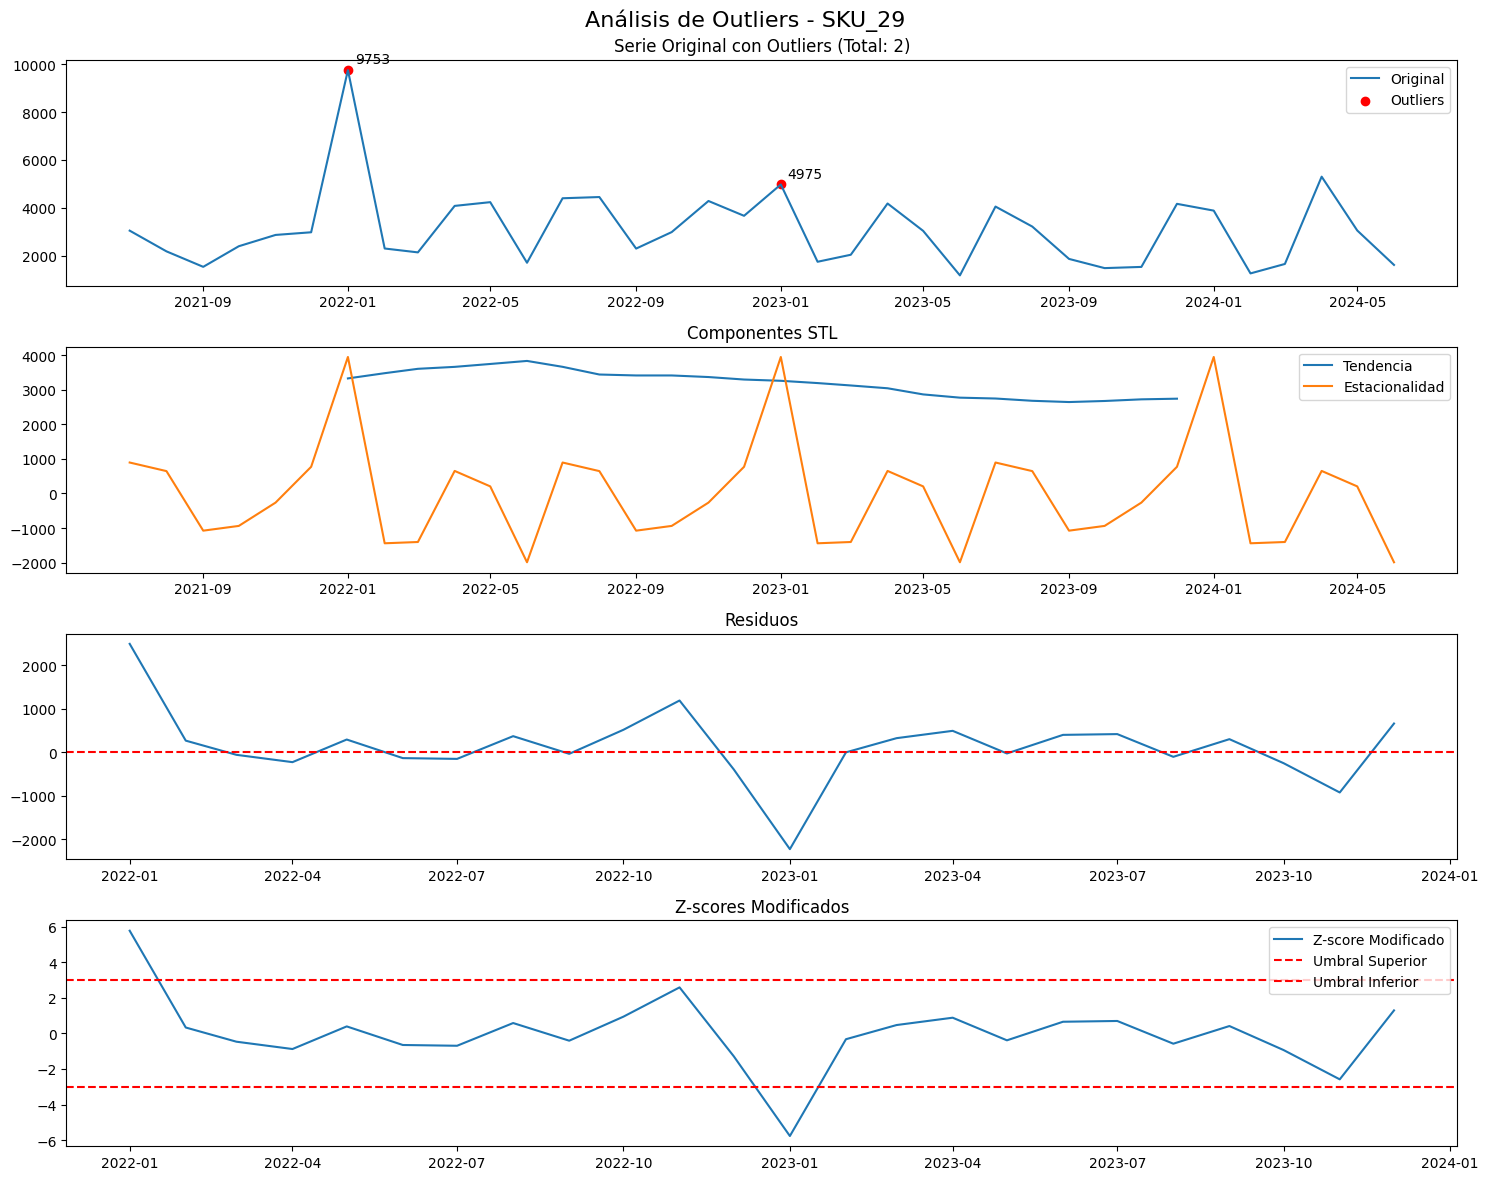

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2663.34722222 1892.38888889]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


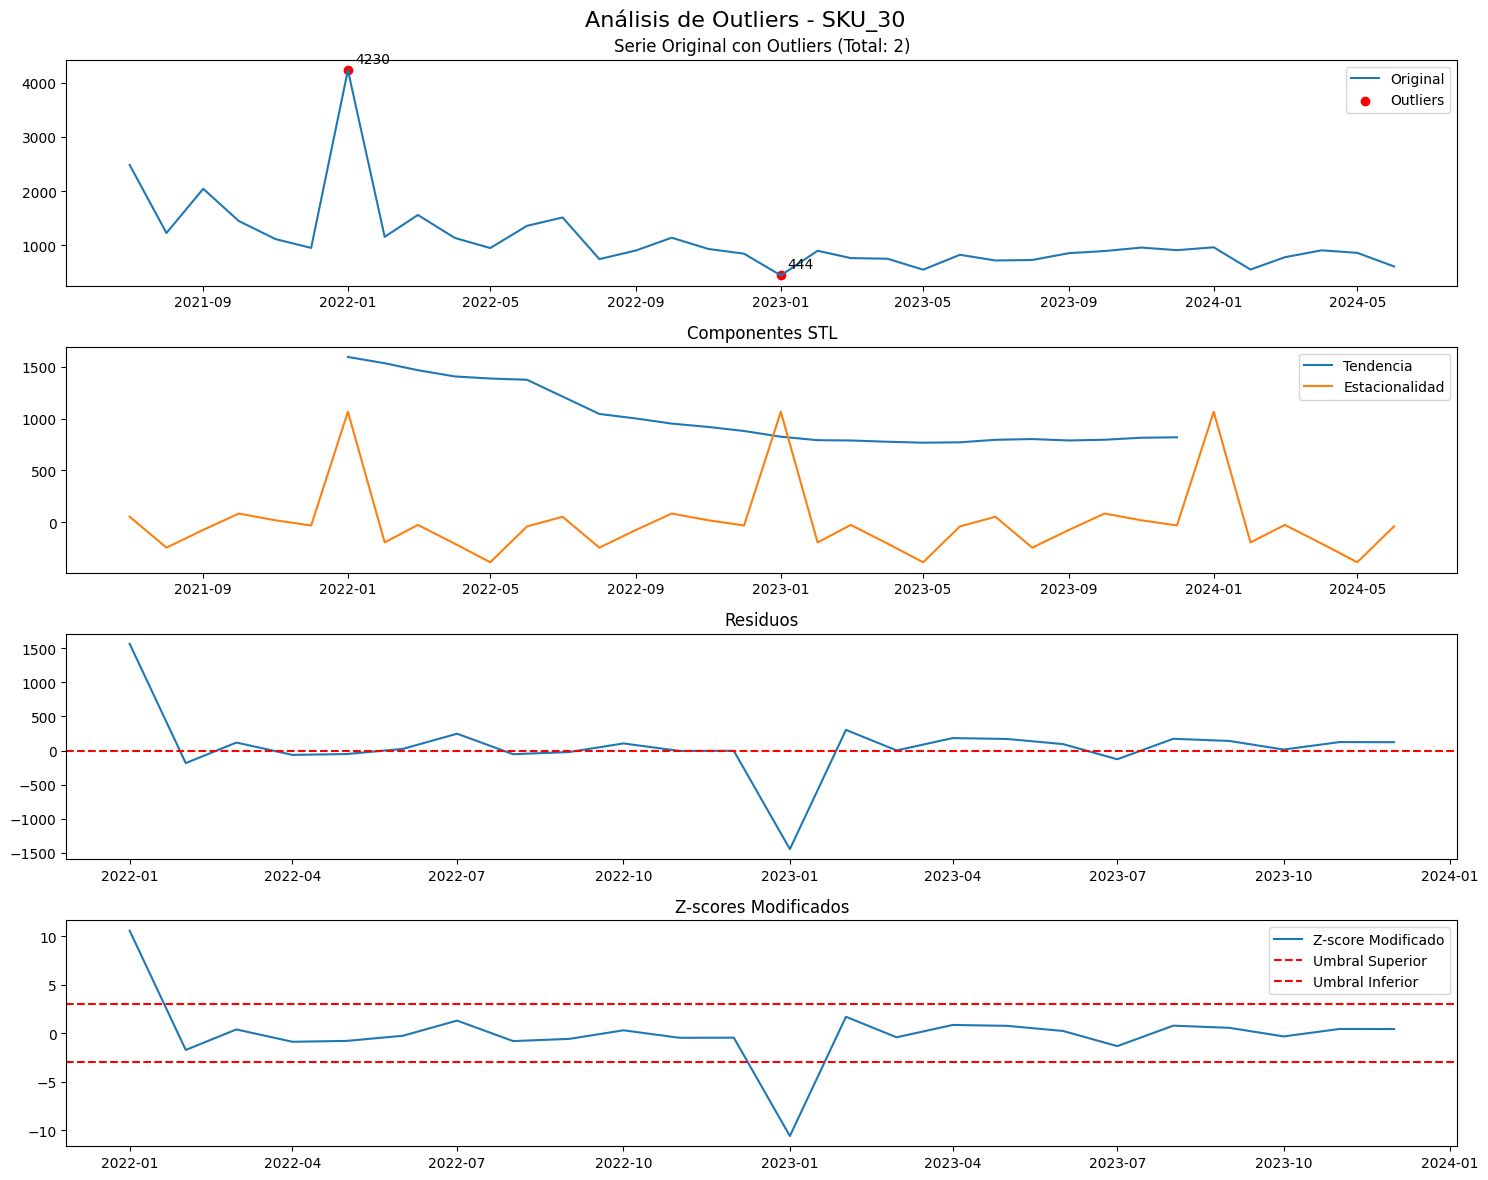

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7974.32118056 4533.86284722 5454.07118056 2006.52951389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


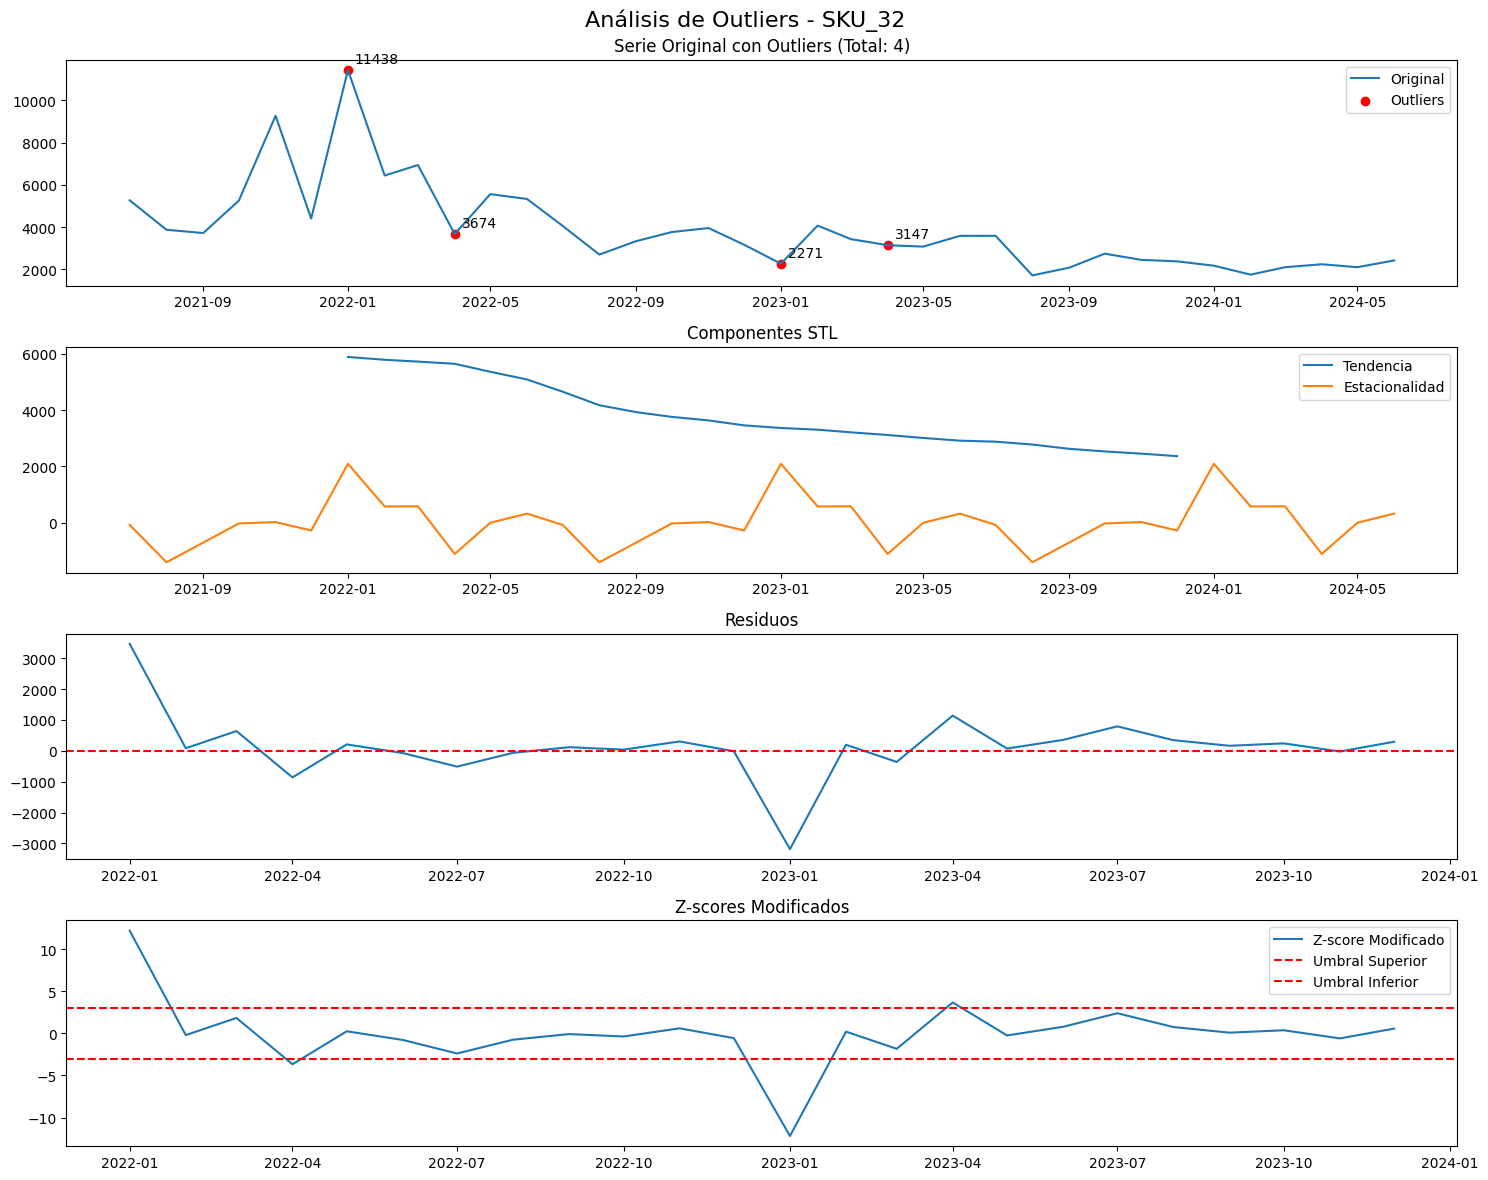

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3073.55208333 2024.65625    2571.26041667 1598.15625   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


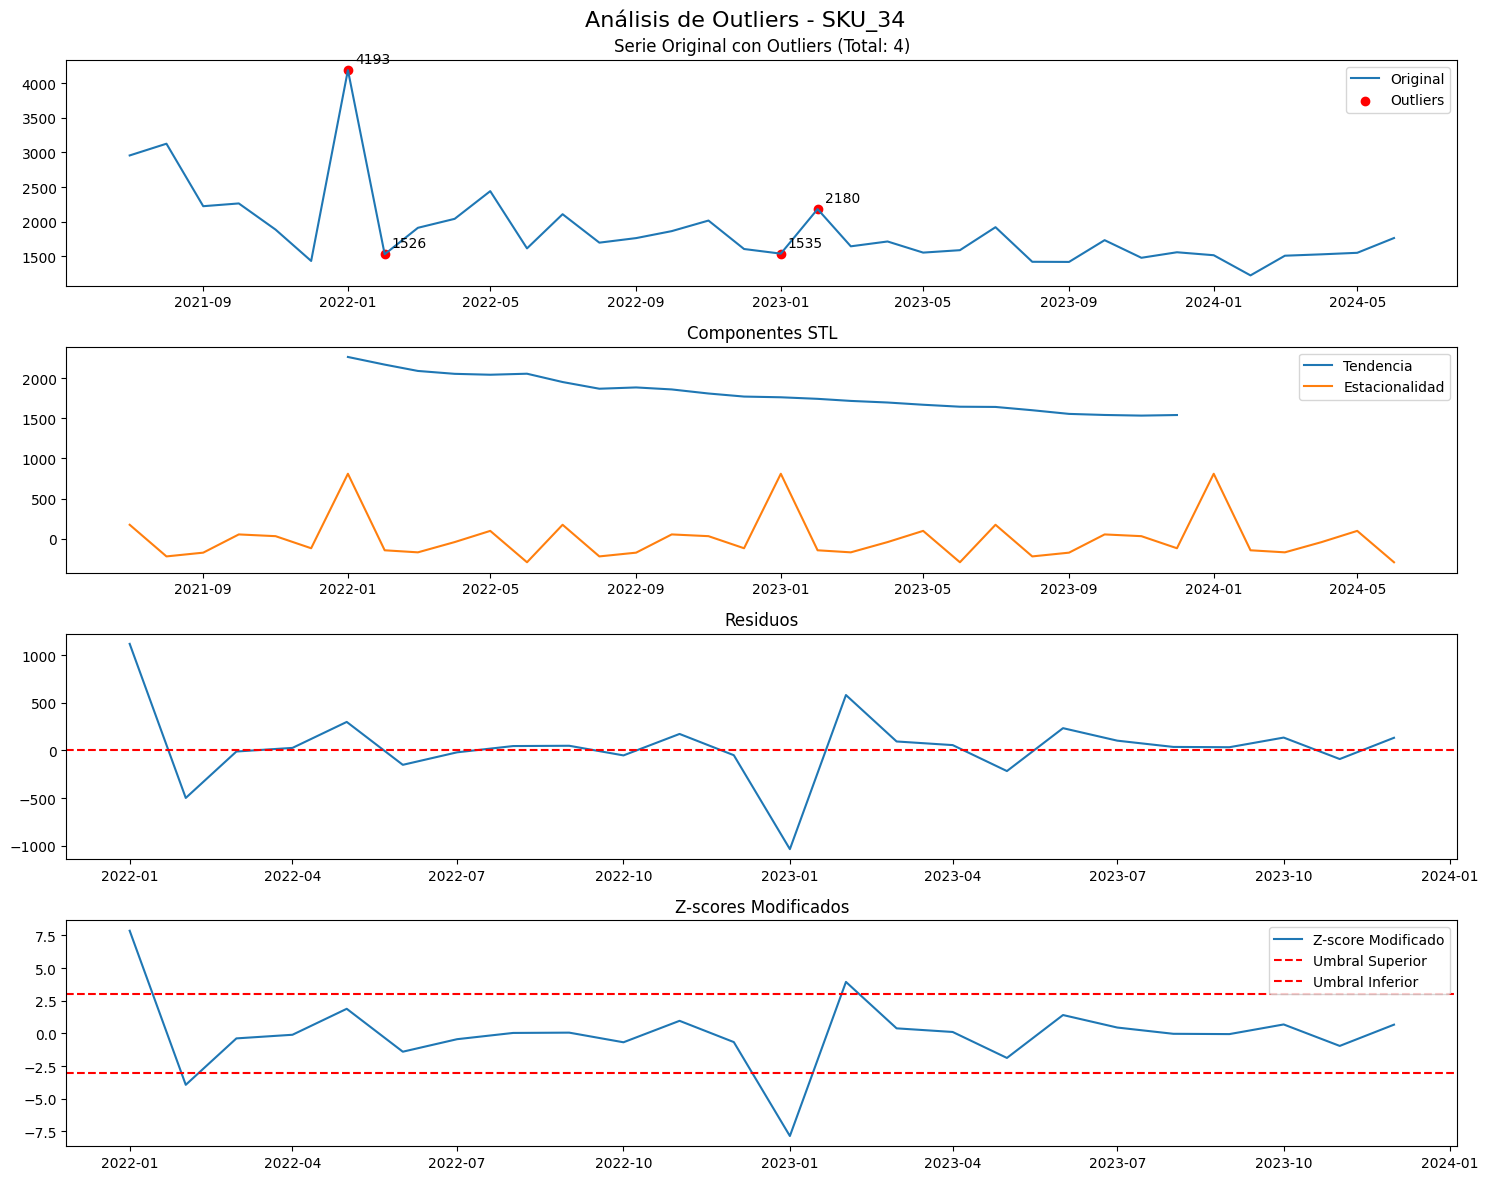

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2153.44444444 1003.86111111]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


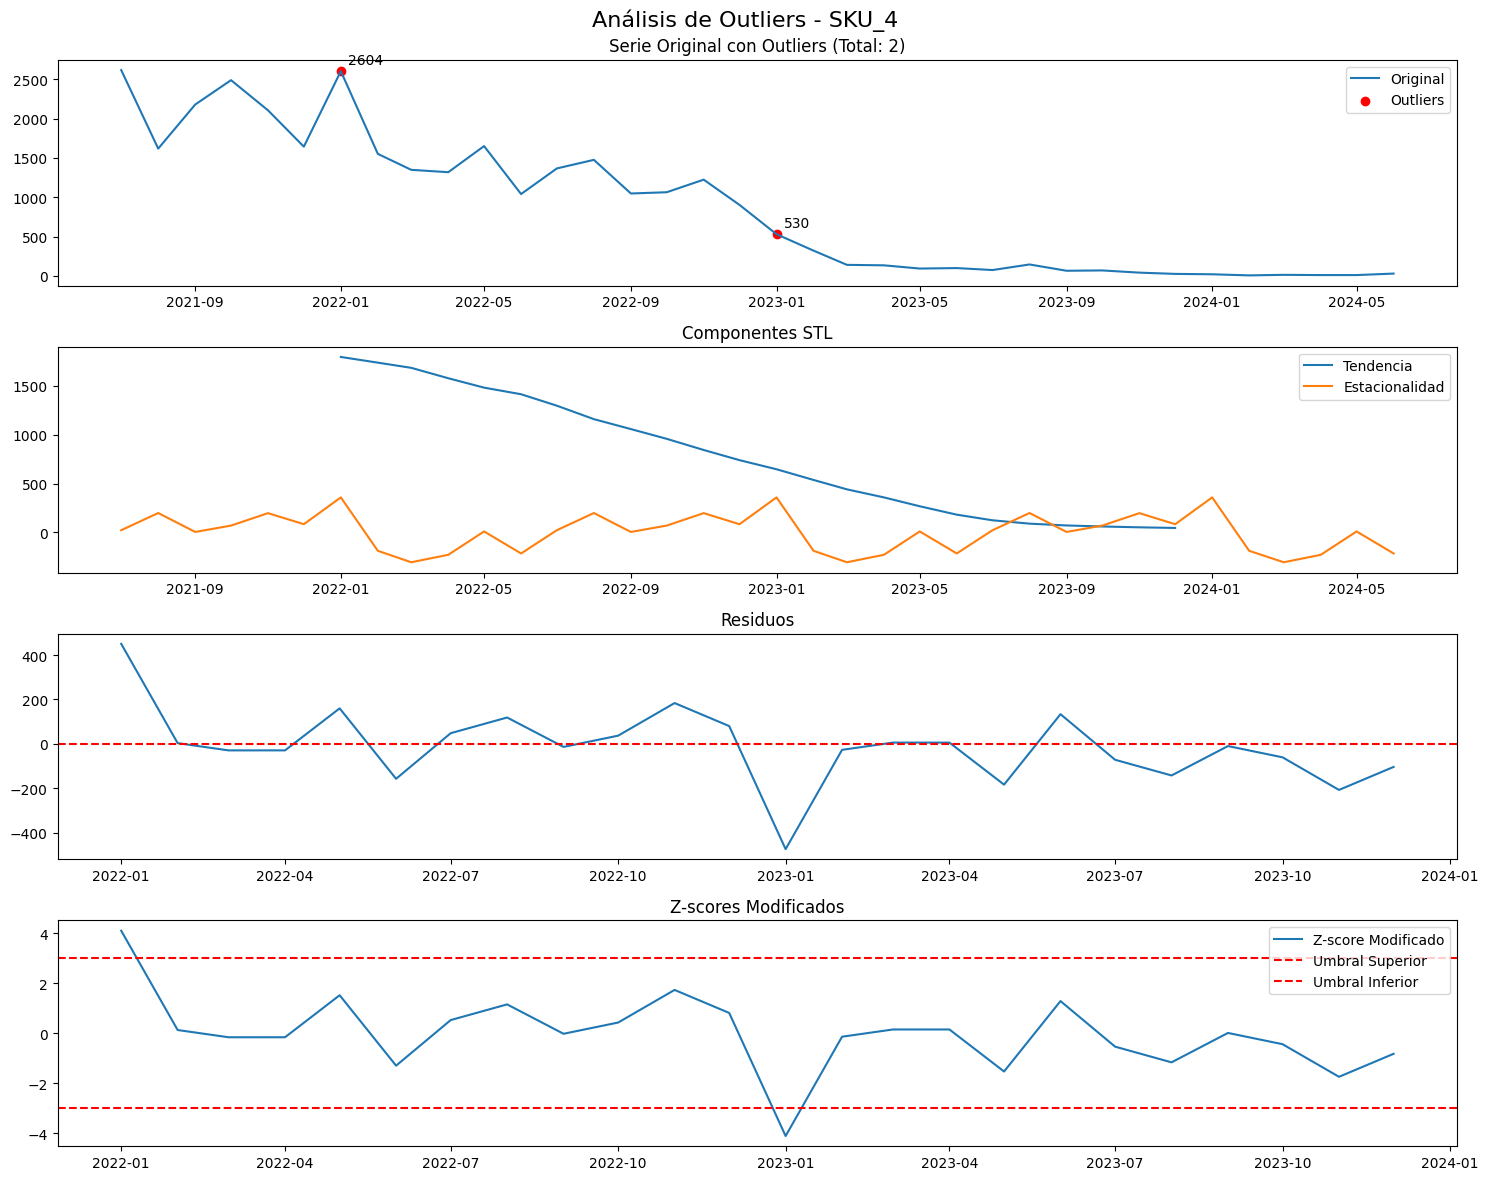

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2165.09375    2055.92708333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


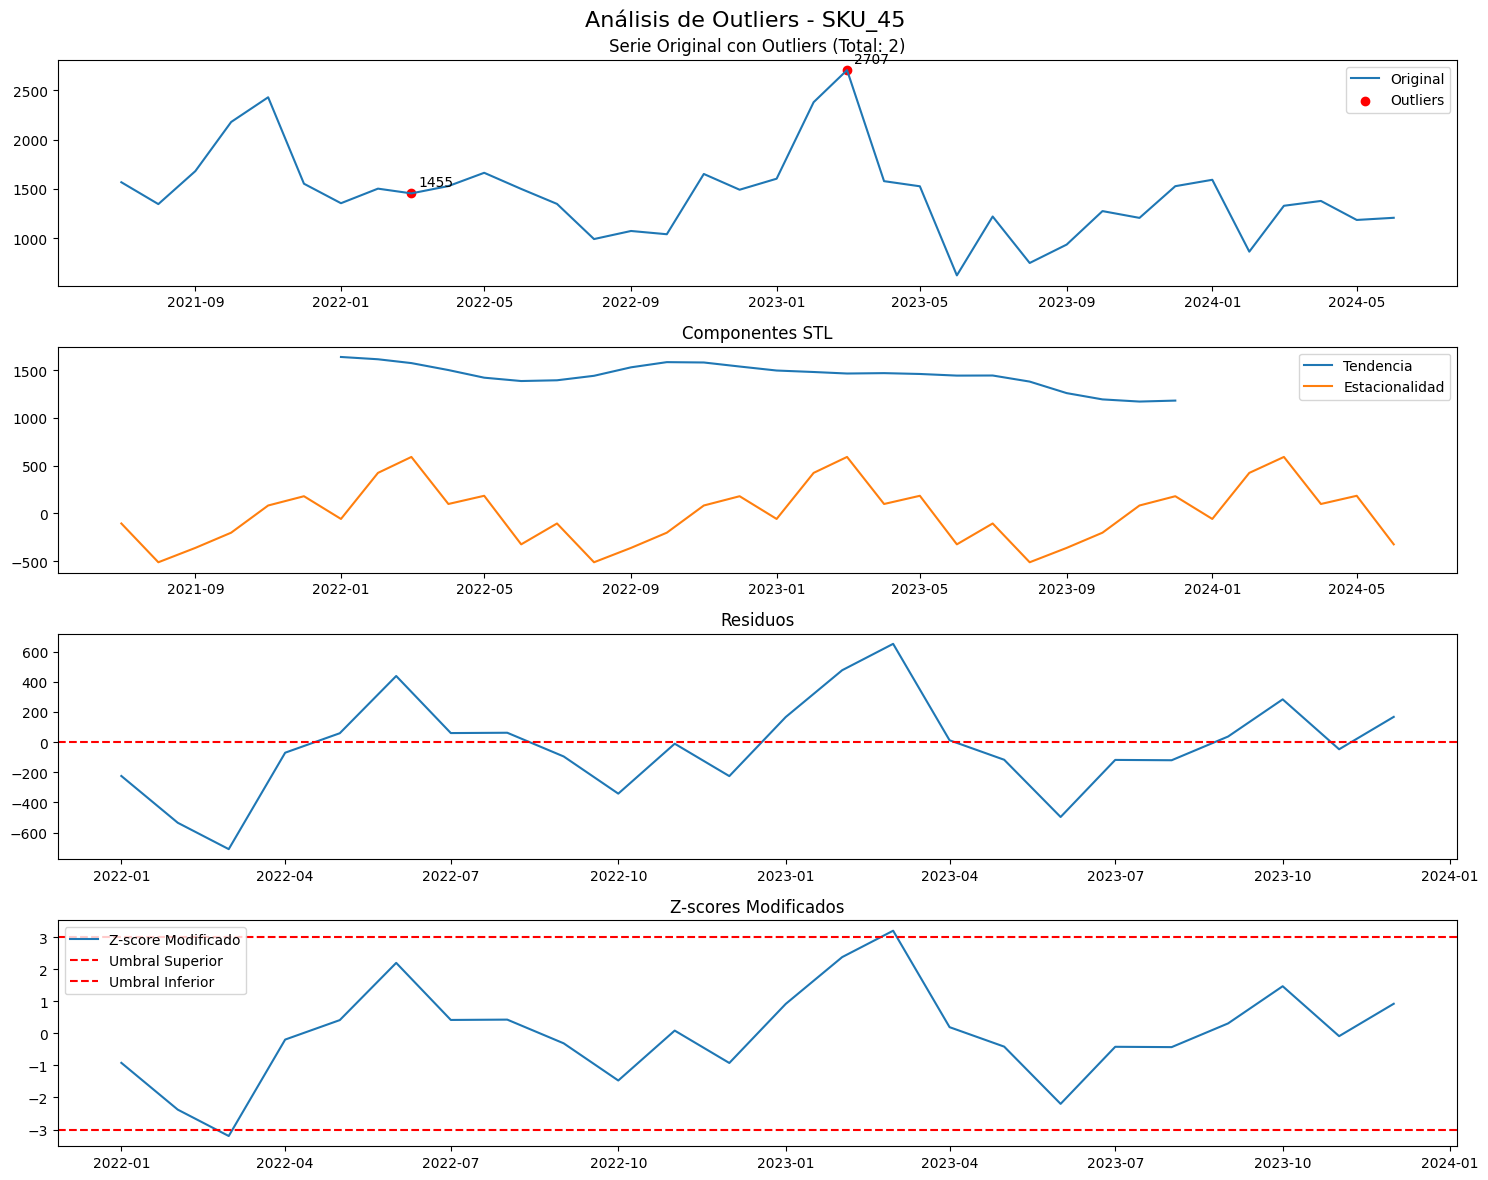

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3231.64756944 3451.81423611]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


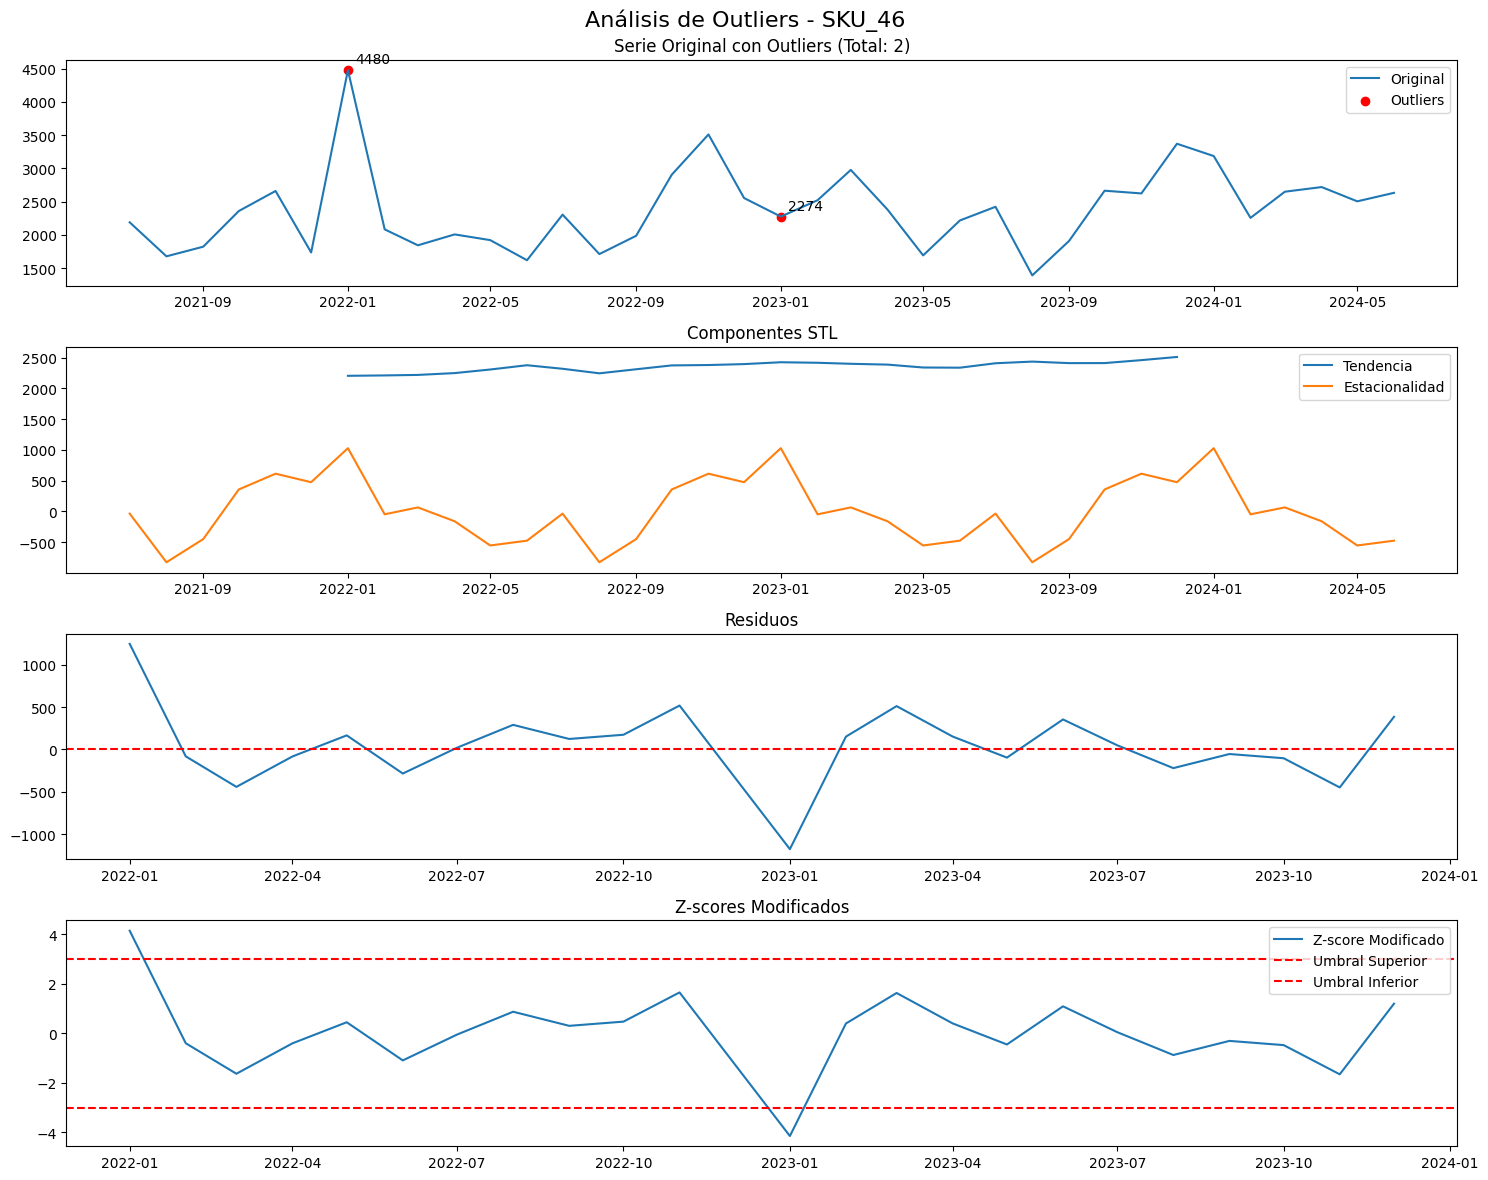

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[33418.06423611 26629.56423611]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


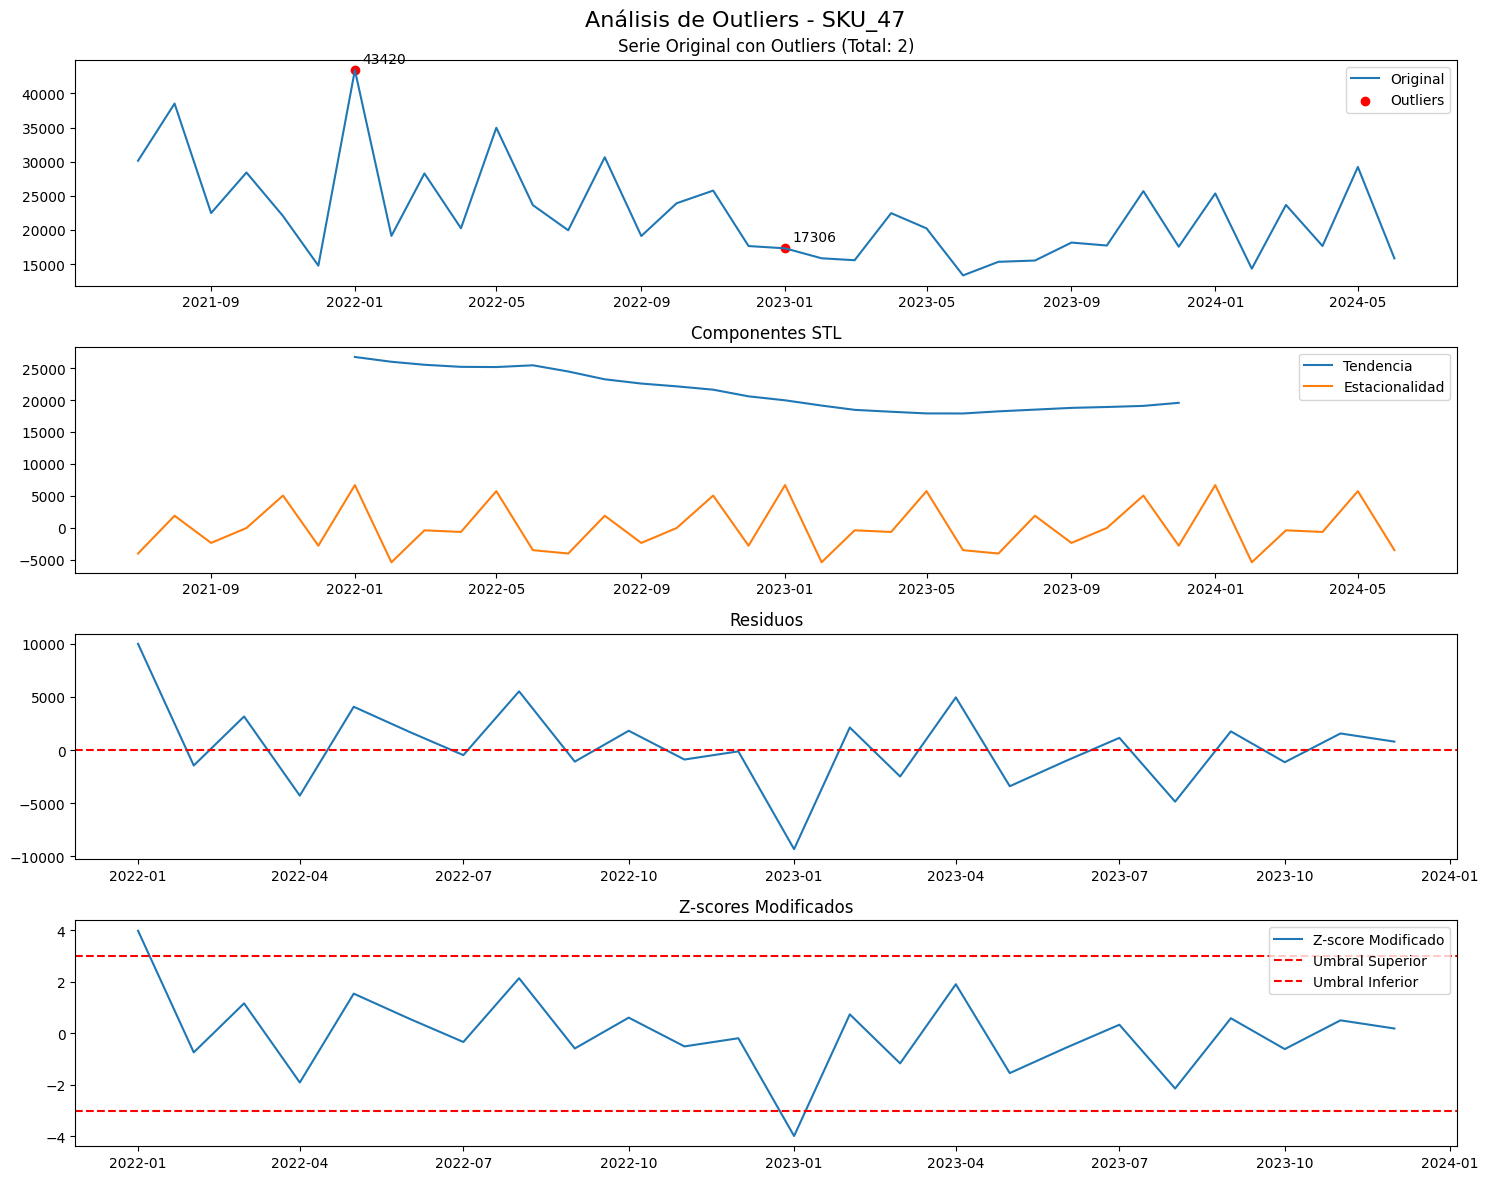

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1380.05034722  978.38368056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


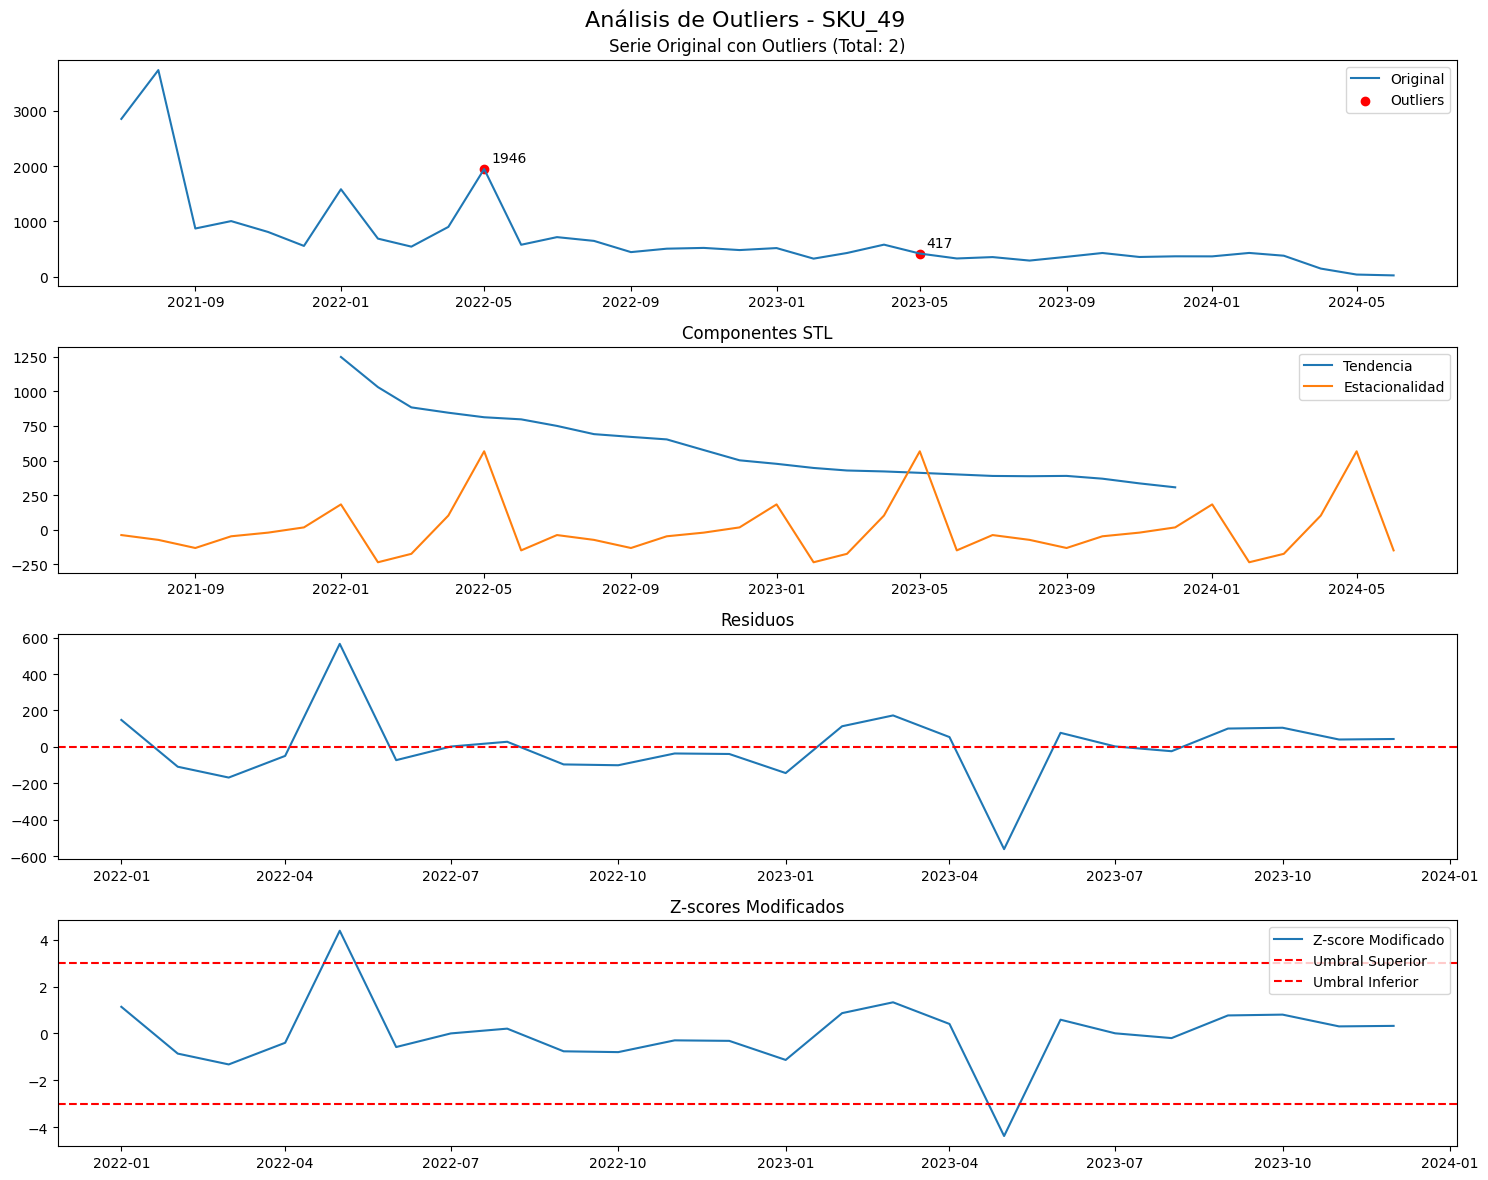

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2011657727.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7546.61111111 7041.44444444]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  treated_series[mask] = expected_values[mask]


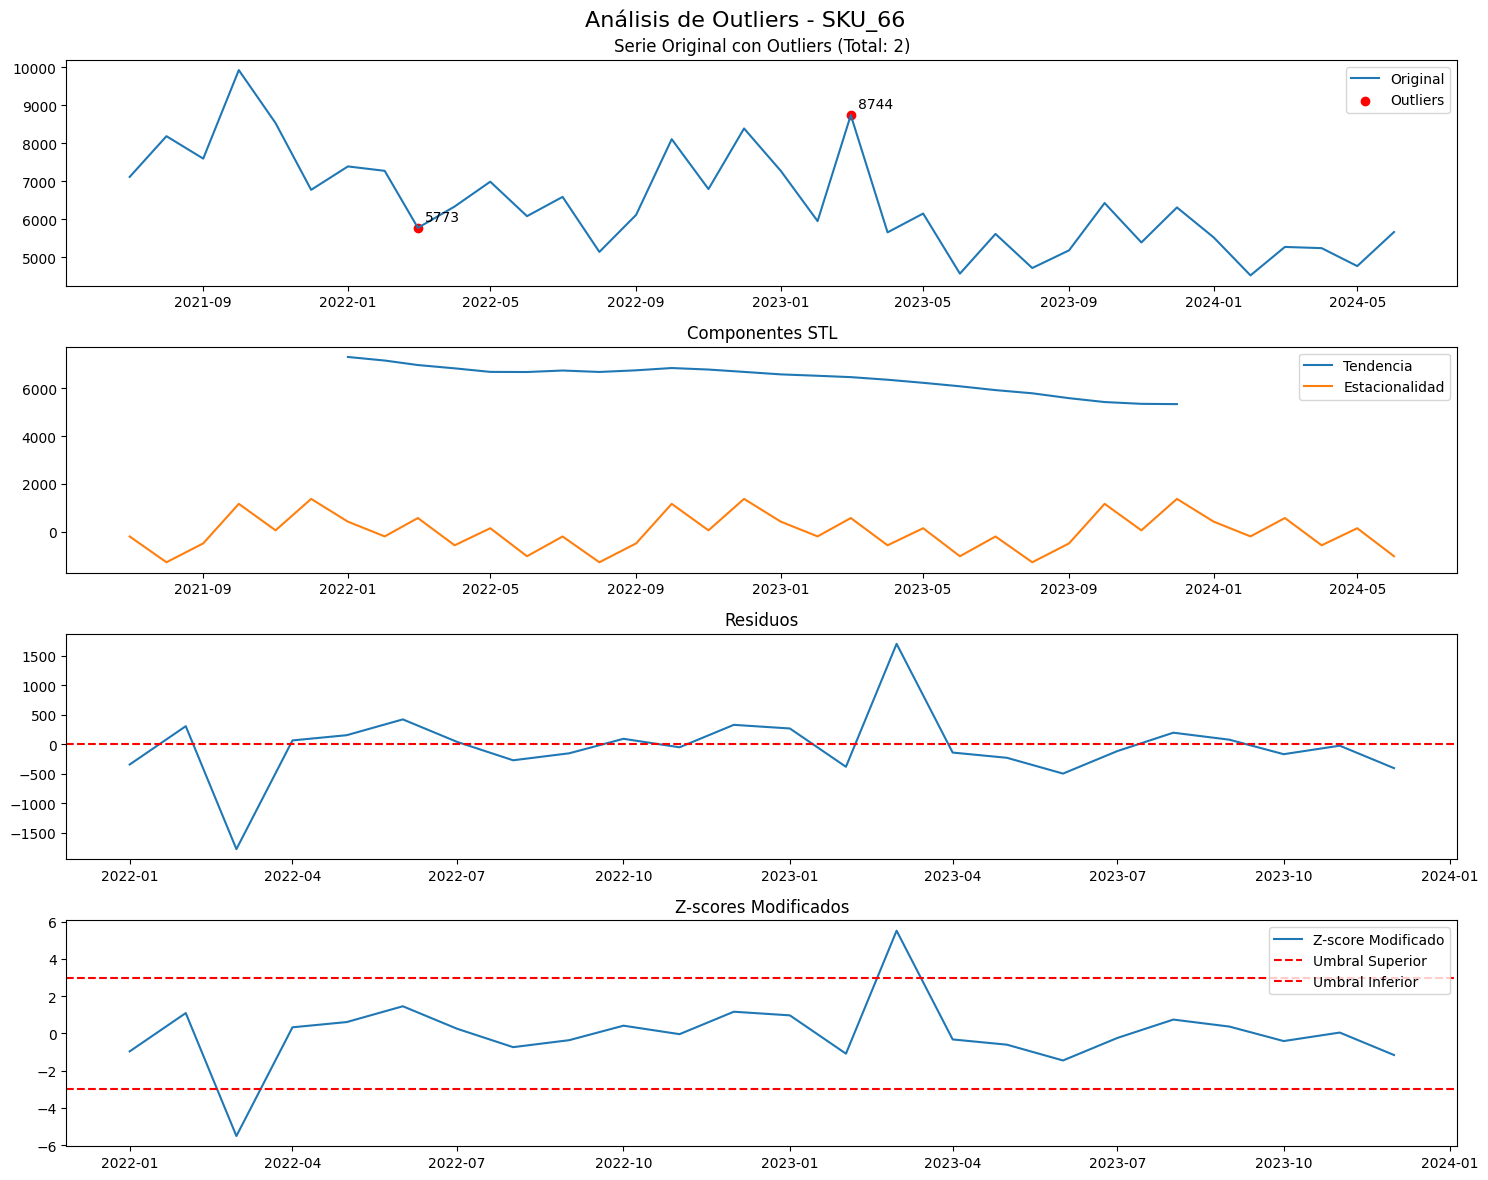


Se encontraron outliers en 13 de 46 SKUs

SKUs con outliers:
- SKU_13: 2 outliers
- SKU_15: 2 outliers
- SKU_16: 2 outliers
- SKU_29: 2 outliers
- SKU_30: 2 outliers
- SKU_32: 4 outliers
- SKU_34: 4 outliers
- SKU_4: 2 outliers
- SKU_45: 2 outliers
- SKU_46: 2 outliers
- SKU_47: 2 outliers
- SKU_49: 2 outliers
- SKU_66: 2 outliers

Resumen de cambios por SKU:
       Valor_Original Diferencia_%              
                count         mean    min    max
SKU                                             
SKU_13              2         0.33 -18.17  18.83
SKU_15              2        -8.68 -72.11  54.74
SKU_16              2        -4.93 -49.01  39.14
SKU_29              2         1.66 -30.89  34.20
SKU_30              2        -8.86 -76.54  58.82
SKU_32              4         5.74 -58.36  56.84
SKU_34              4         1.98 -40.30  36.42
SKU_4               2       -13.14 -47.20  20.92
SKU_45              2        -0.56 -32.80  31.67
SKU_46              2         2.26 -34.12  38.63


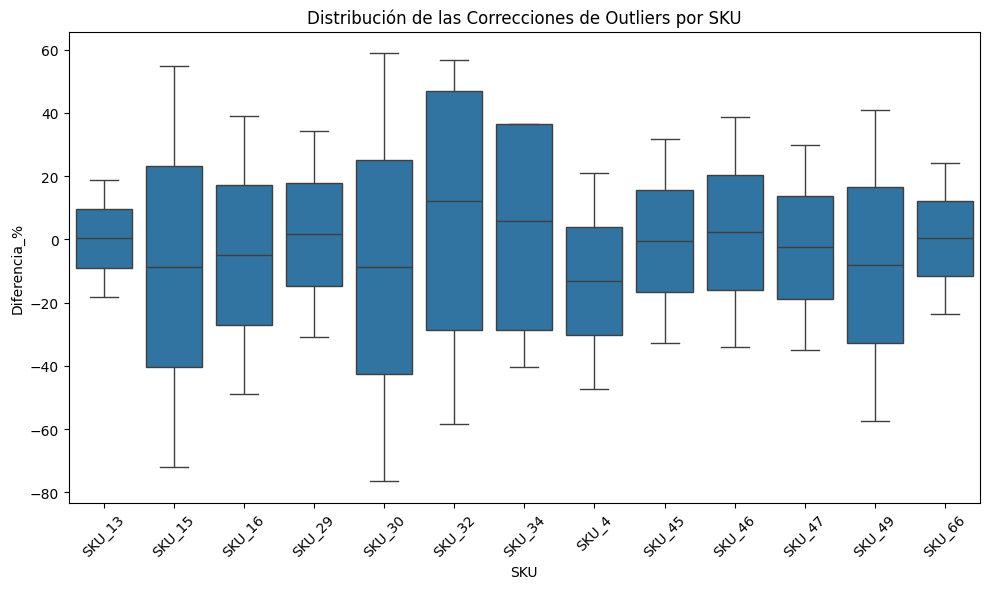

In [15]:
# Ejecutar el análisis
resultados = analyze_sales_outliers(data, period=12)

# Si hay outliers, generar y mostrar el reporte
if resultados:
    reporte = generate_outlier_report(resultados)
    
    if not reporte.empty:
        print("\nResumen de cambios por SKU:")
        resumen = reporte.groupby('SKU').agg({
            'Valor_Original': 'count',
            'Diferencia_%': ['mean', 'min', 'max']
        }).round(2)
        print(resumen)
        
        # Visualizar distribución de las correcciones
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=reporte, x='SKU', y='Diferencia_%')
        plt.xticks(rotation=45)
        plt.title('Distribución de las Correcciones de Outliers por SKU')
        plt.tight_layout()
        plt.show()

In [21]:
def create_comparison_dataset(results):
    """
    Crea un DataFrame comparativo con valores originales y tratados
    
    Args:
        results: Diccionario con resultados del análisis
    
    Returns:
        DataFrame con valores originales y tratados
    """
    # Crear listas para almacenar los datos
    data_list = []
    
    for sku, data in results.items():
        analysis = data['analysis']
        original_series = data['original']
        treated_series = data['treated']
        
        for fecha in original_series.index:
            is_outlier = analysis.loc[fecha, 'is_outlier']
            if is_outlier:
                data_list.append({
                    'SKU': sku,
                    'Fecha': fecha,
                    'Valor_Original': original_series[fecha],
                    'Valor_Tratado': treated_series[fecha],
                    'Diferencia': original_series[fecha] - treated_series[fecha],
                    'Diferencia_%': ((original_series[fecha] - treated_series[fecha]) / treated_series[fecha] * 100).round(2),
                    'Z_score': analysis.loc[fecha, 'modified_zscore'],
                    'Es_Outlier': 'Sí'
                })
            else:
                data_list.append({
                    'SKU': sku,
                    'Fecha': fecha,
                    'Valor_Original': original_series[fecha],
                    'Valor_Tratado': original_series[fecha],
                    'Diferencia': 0,
                    'Diferencia_%': 0,
                    'Z_score': analysis.loc[fecha, 'modified_zscore'],
                    'Es_Outlier': 'No'
                })
    
    # Crear DataFrame
    df_comparison = pd.DataFrame(data_list)
    
    # Ordenar por SKU y Fecha
    df_comparison = df_comparison.sort_values(['SKU', 'Fecha'])
    
    return df_comparison

def get_outliers_summary(df_comparison):
    """
    Genera un resumen estadístico de los outliers
    
    Args:
        df_comparison: DataFrame con la comparación de valores
    
    Returns:
        DataFrame con el resumen por SKU
    """
    # Filtrar solo outliers
    outliers_only = df_comparison[df_comparison['Es_Outlier'] == 'Sí']
    
    # Crear resumen por SKU
    summary = outliers_only.groupby('SKU').agg({
        'Es_Outlier': 'count',
        'Diferencia': ['mean', 'min', 'max'],
        'Diferencia_%': ['mean', 'min', 'max'],
        'Z_score': ['mean', 'min', 'max']
    }).round(2)
    
    # Renombrar columnas
    summary.columns = [
        'Cantidad_Outliers',
        'Diferencia_Media',
        'Diferencia_Min',
        'Diferencia_Max',
        'Diferencia_%_Media',
        'Diferencia_%_Min',
        'Diferencia_%_Max',
        'Z_score_Medio',
        'Z_score_Min',
        'Z_score_Max'
    ]
    
    return summary

def export_results(df_comparison, summary, filename_prefix='outliers'):
    """
    Exporta los resultados a archivos Excel
    
    Args:
        df_comparison: DataFrame con la comparación detallada
        summary: DataFrame con el resumen
        filename_prefix: Prefijo para los nombres de archivo
    """
    # Crear un escritor de Excel
    with pd.ExcelWriter(f'{filename_prefix}_analisis.xlsx') as writer:
        # Exportar datos detallados
        df_comparison.to_excel(writer, sheet_name='Datos_Detallados', index=False)
        
        # Exportar resumen
        summary.to_excel(writer, sheet_name='Resumen')

# Ejemplo de uso en Streamlit:
import streamlit as st

def show_outliers_analysis(results):
    """
    Muestra el análisis de outliers en Streamlit
    
    Args:
        results: Diccionario con resultados del análisis
    """
    # Crear dataset comparativo
    df_comparison = create_comparison_dataset(results)
    
    # Crear resumen
    summary = get_outliers_summary(df_comparison)
    
    # Mostrar resumen
    st.subheader("Resumen de Outliers por SKU")
    st.dataframe(summary)
    
    # Selector de vista
    view_option = st.radio(
        "Seleccionar vista de datos:",
        ["Todos los datos", "Solo outliers", "Resumen por SKU"]
    )
    
    if view_option == "Todos los datos":
        st.dataframe(df_comparison)
    elif view_option == "Solo outliers":
        st.dataframe(df_comparison[df_comparison['Es_Outlier'] == 'Sí'])
    else:
        st.dataframe(summary)
    
    # Botón para descargar datos
    if st.button("Descargar resultados en Excel"):
        export_results(df_comparison, summary)
        st.success("Datos exportados exitosamente!")
    
    # Mostrar estadísticas generales
    st.subheader("Estadísticas Generales")
    total_outliers = (df_comparison['Es_Outlier'] == 'Sí').sum()
    total_registros = len(df_comparison)
    
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Total de Outliers", total_outliers)
    with col2:
        st.metric("Total de Registros", total_registros)
    with col3:
        st.metric("Porcentaje de Outliers", f"{(total_outliers/total_registros*100):.2f}%")

In [24]:
from openpyxl import Workbook
# Después de ejecutar analyze_sales_outliers
results, figures, skus_con_outliers = analyze_sales_outliers(data, period=12)

# Ver el dataset completo con los resultados
df_comparison = create_comparison_dataset(results)
print("\nPrimeras filas del dataset con resultados:")
print(df_comparison.head())

# Ver resumen estadístico
summary = get_outliers_summary(df_comparison)
print("\nResumen por SKU:")
print(summary)

# Exportar resultados
export_results(df_comparison, summary)

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2499186807.py:179: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2161.92534722 1960.17534722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2499186807.py:179: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7491.47743056 5339.43576389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\norma\AppData\Local\Temp\ipykernel_28888\2499186807.py:179: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6913.92881944 5481.05381944]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\norma\AppData\Local\Temp\ipykernel_28


Primeras filas del dataset con resultados:
      SKU      Fecha  Valor_Original  Valor_Tratado  Diferencia  Diferencia_%  \
0  SKU_13 2021-07-01            1058         1058.0         0.0           0.0   
1  SKU_13 2021-08-01            1245         1245.0         0.0           0.0   
2  SKU_13 2021-09-01            1133         1133.0         0.0           0.0   
3  SKU_13 2021-10-01            1837         1837.0         0.0           0.0   
4  SKU_13 2021-11-01            1721         1721.0         0.0           0.0   

   Z_score Es_Outlier  
0      NaN         No  
1      NaN         No  
2      NaN         No  
3      NaN         No  
4      NaN         No  

Resumen por SKU:
        Cantidad_Outliers  Diferencia_Media  Diferencia_Min  Diferencia_Max  \
SKU                                                                           
SKU_13                  2             25.45         -356.18          407.07   
SKU_15                  2            125.04        -3850.44         41

### Gráficos interactivos con Plotly para Streamlit

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_outlier_analysis_interactive(analysis_results, sku_name):
    """
    Crea una visualización interactiva de los resultados del análisis de outliers
    
    Args:
        analysis_results: DataFrame con los resultados del análisis
        sku_name: Nombre del SKU para el título
    
    Returns:
        figura de Plotly
    """
    # Crear subplots
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=(
            'Serie Original con Outliers',
            'Componentes STL',
            'Residuos',
            'Z-scores Modificados'
        ),
        vertical_spacing=0.1
    )
    
    # Serie original con outliers
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=analysis_results['original'],
            name='Original',
            line=dict(color='blue')
        ),
        row=1, col=1
    )
    
    # Agregar outliers como puntos
    outliers = analysis_results[analysis_results['is_outlier']]
    if not outliers.empty:
        fig.add_trace(
            go.Scatter(
                x=outliers.index,
                y=outliers['original'],
                mode='markers+text',
                name='Outliers',
                marker=dict(color='red', size=10),
                text=outliers['original'].round(0),
                textposition="top center",
                hovertemplate="Fecha: %{x}<br>" +
                            "Valor: %{y}<br>" +
                            "<extra></extra>"
            ),
            row=1, col=1
        )
    
    # Componentes STL
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=analysis_results['trend'],
            name='Tendencia',
            line=dict(color='green')
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=analysis_results['seasonal'],
            name='Estacionalidad',
            line=dict(color='orange')
        ),
        row=2, col=1
    )
    
    # Residuos
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=analysis_results['residual'],
            name='Residuos',
            line=dict(color='purple')
        ),
        row=3, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=[0] * len(analysis_results),
            name='Línea Base',
            line=dict(color='red', dash='dash')
        ),
        row=3, col=1
    )
    
    # Z-scores
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=analysis_results['modified_zscore'],
            name='Z-score Modificado',
            line=dict(color='blue')
        ),
        row=4, col=1
    )
    
    # Agregar líneas de umbral
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=[3] * len(analysis_results),
            name='Umbral Superior',
            line=dict(color='red', dash='dash')
        ),
        row=4, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=analysis_results.index,
            y=[-3] * len(analysis_results),
            name='Umbral Inferior',
            line=dict(color='red', dash='dash')
        ),
        row=4, col=1
    )
    
    # Actualizar layout
    fig.update_layout(
        title_text=f"Análisis de Outliers - {sku_name}",
        height=900,
        showlegend=True,
        hovermode='x unified'
    )
    
    # Actualizar ejes y
    fig.update_yaxes(title_text="Cantidad", row=1, col=1)
    fig.update_yaxes(title_text="Valor", row=2, col=1)
    fig.update_yaxes(title_text="Residuos", row=3, col=1)
    fig.update_yaxes(title_text="Z-score", row=4, col=1)
    
    return fig

def analyze_sales_outliers(df_original, period=12):
    """
    Analiza outliers y devuelve resultados y figuras para Streamlit
    
    Args:
        df_original: DataFrame con columnas [id_sku, AAAAMM, fecha, Cantidad]
        period: Período de estacionalidad
    
    Returns:
        dict con resultados y figuras por SKU
    """
    df = prepare_data_for_analysis(df_original)
    results = {}
    figures = {}
    skus_con_outliers = []
    
    for sku in df.columns:
        series = df[sku].copy()
        
        try:
            analysis = detect_outliers_combined(series, period=period)
            
            if analysis['is_outlier'].any():
                skus_con_outliers.append(sku)
                
                treated_series = series.copy()
                mask = analysis['is_outlier']
                expected_values = analysis['trend'] + analysis['seasonal']
                treated_series[mask] = expected_values[mask]
                
                results[sku] = {
                    'original': series,
                    'treated': treated_series,
                    'analysis': analysis,
                    'num_outliers': mask.sum()
                }
                
                # Crear figura interactiva
                figures[sku] = plot_outlier_analysis_interactive(analysis, sku)
            
        except Exception as e:
            print(f"Error al procesar {sku}: {str(e)}")
            continue
    
    return results, figures, skus_con_outliers

# Función para crear un gráfico de resumen interactivo
def create_summary_plot(reporte):
    """
    Crea un gráfico de resumen interactivo para Streamlit
    
    Args:
        reporte: DataFrame con el reporte de outliers
    
    Returns:
        figura de Plotly
    """
    fig = go.Figure()
    
    for sku in reporte['SKU'].unique():
        sku_data = reporte[reporte['SKU'] == sku]
        
        fig.add_trace(go.Box(
            y=sku_data['Diferencia_%'],
            name=sku,
            boxpoints='all',
            jitter=0.3,
            pointpos=-1.8,
            hovertemplate="SKU: %{x}<br>" +
                        "Diferencia: %{y:.2f}%<br>" +
                        "<extra></extra>"
        ))
    
    fig.update_layout(
        title="Distribución de las Correcciones de Outliers por SKU",
        yaxis_title="Diferencia (%)",
        showlegend=False,
        height=600
    )
    
    return fig

In [20]:
import streamlit as st

# Título de la aplicación
st.title("Análisis de Outliers en Series de Ventas")

# Cargar y procesar datos
uploaded_file = st.file_uploader("Cargar archivo de datos", type=['csv'])
if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    
    # Analizar outliers
    results, figures, skus_con_outliers = analyze_sales_outliers(df, period=12)
    
    # Mostrar resumen
    st.write(f"Se encontraron outliers en {len(skus_con_outliers)} de {len(df['id_sku'].unique())} SKUs")
    
    # Selector de SKU
    if skus_con_outliers:
        selected_sku = st.selectbox("Seleccionar SKU para ver análisis", skus_con_outliers)
        
        # Mostrar gráfico del SKU seleccionado
        st.plotly_chart(figures[selected_sku], use_container_width=True)
        
        # Generar y mostrar reporte
        reporte = generate_outlier_report(results)
        if not reporte.empty:
            st.write("Resumen de cambios:")
            st.dataframe(reporte[reporte['SKU'] == selected_sku])
            
            # Mostrar gráfico de resumen
            st.plotly_chart(create_summary_plot(reporte), use_container_width=True)

2025-02-14 21:05:51.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.974 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 21:05:51.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


### Segmentar las series

In [ ]:
# Calcular promedios y totales de ventas por producto
resumen_ventas = data.groupby('id_sku')['Cantidad'].agg(['mean', 'sum']).reset_index()

In [ ]:
resumen_ventas['mean'].quantile([0.4, 0.8, 0.99])

In [ ]:
resumen_ventas['sum'].quantile([0.4, 0.8, 0.99])

In [ ]:
# Clasificar por percentiles
def clasificar_por_percentiles(ventas, percentiles):
    limites = ventas.quantile(percentiles).values
    etiquetas = ['Bajas', 'Promedio', 'Top']
    return pd.cut(ventas, bins=[0] + list(limites) + [ventas.max()], labels=etiquetas, right=False)

resumen_ventas['rango_total'] = clasificar_por_percentiles(resumen_ventas['sum'], [0.5, 0.8])

In [ ]:
resumen_ventas['rango_total'].value_counts()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Pruebas estadísticas y nuevas variables (sin pruebas de normalidad)
def pruebas_estadisticas(serie):
    # Prueba de Dickey-Fuller Aumentada (ADF)
    resultado_adf = adfuller(serie)
    es_estacionaria = resultado_adf[1] < 0.05

    # Descomposición estacional (para evaluar estacionalidad y tendencia)
    try:
        decomposition = seasonal_decompose(serie, model='additive', period=12)  # Ajustar 'period' según la frecuencia
        tendencia = decomposition.trend.dropna().values  # Obtener la tendencia, ignorando valores NaN
        tiene_tendencia = len(tendencia) > 0 and abs(np.mean(np.diff(tendencia))) > 0.1  # Umbral de 0.1 ajustable
        tiene_estacionalidad = abs(np.mean(decomposition.seasonal.dropna().values)) > 0.1  # Umbral de 0.1 ajustable

        # Graficar componentes de la descomposición (opcional)
        decomposition.plot()
        plt.show()

    except Exception as e:
        print(f"Error en descomposición estacional: {e}")
        tiene_tendencia = False
        tiene_estacionalidad = False

    return pd.Series({
        'es_estacionaria': es_estacionaria,
        'tiene_tendencia': tiene_tendencia,
        'tiene_estacionalidad': tiene_estacionalidad,
    })

resultados_pruebas = data.groupby('producto')['ventas'].apply(pruebas_estadisticas).unstack()

In [ ]:
# Unir resultados a la tabla de resumen
resumen_ventas = resumen_ventas.merge(resultados_pruebas, on='producto')
resumen_ventas.head()

In [ ]:
# Ejemplo de análisis por grupo (basado en resultados de pruebas)
for rango in resumen_ventas['rango_promedio'].unique():
    productos_grupo = resumen_ventas[resumen_ventas['rango_promedio'] == rango]
    print(f"\nAnálisis para productos con ventas promedio {rango}:")
    # Análisis basado en 'es_estacionaria', 'tiene_tendencia', 'tiene_estacionalidad', etc.
    # ... (código para realizar análisis exploratorio específico para cada grupo)